# Stock Valuation

This project aims to try and determine whether a stock price is fairly valued, undervalued or overvalued by making use of a variety of metrics. At present this is still a work in progress.

## Company Information

This code is a template for use later on when more company information is required to assess the value of a stock.

In [1]:
import yfinance as yf

# Example stock symbol
stock_symbol = 'AAPL'

# Create a Ticker object
ticker = yf.Ticker(stock_symbol)

# Get stock information
info = ticker.info

# Access specific metrics
pe_ratio = info.get('trailingPE', None)  # P/E ratio
forward_pe = info.get('forwardPE', None)  # Forward P/E ratio
peg_ratio = info.get('pegRatio', None)  # PEG ratio
price_to_book = info.get('priceToBook', None)  # Price/Book ratio
enterprise_to_revenue = info.get('enterpriseToRevenue', None)  # Enterprise Value/Revenue
enterprise_to_ebitda = info.get('enterpriseToEbitda', None)  # Enterprise Value/EBITDA

# Cash flow data is not directly available through the `info` attribute. 
# You need to use `cashflow` for the cash flow statement:
cash_flow_statement = ticker.cashflow

# Print the metrics
print(f"Stock: {stock_symbol}")
print(f"P/E Ratio: {pe_ratio}")
print(f"Forward P/E Ratio: {forward_pe}")
print(f"PEG Ratio: {peg_ratio}")
print(f"Price to Book Ratio: {price_to_book}")
print(f"Enterprise to Revenue: {enterprise_to_revenue}")
print(f"Enterprise to EBITDA: {enterprise_to_ebitda}")
print("\nCash Flow Statement (Annual):")
print(cash_flow_statement)

# Note: The cash flow statement provided here is annual by default. 
# You can get quarterly data by passing `quarterly=True` to `cashflow`.

Stock: AAPL
P/E Ratio: 26.286112
Forward P/E Ratio: 23.639118
PEG Ratio: 2.34
Price to Book Ratio: 35.263863
Enterprise to Revenue: 6.835
Enterprise to EBITDA: 20.261

Cash Flow Statement (Annual):
                                                    2023-09-30  \
Free Cash Flow                                   99584000000.0   
Repurchase Of Capital Stock                     -77550000000.0   
Repayment Of Debt                               -11151000000.0   
Issuance Of Debt                                  5228000000.0   
Issuance Of Capital Stock                                  NaN   
Capital Expenditure                             -10959000000.0   
Interest Paid Supplemental Data                   3803000000.0   
Income Tax Paid Supplemental Data                18679000000.0   
End Cash Position                                30737000000.0   
Beginning Cash Position                          24977000000.0   
Changes In Cash                                   5760000000.0   
Financing 

***

# Value Analysis

### Information Technology Sector

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_df = pd.read_html(url, header=0)[0] # S&P500 dataset

In [3]:
def fetch_metrics(tickers):
    """Fetches financial metrics for a list of tickers according to Benjamin Graham's principles."""
    metrics = {'PE_Ratio': [], 'PB_Ratio': [], 'EPS_Growth': [], 'Dividend_Yield': [], 'Current_Ratio': [], 'Debt_to_Equity': []}
    for ticker in tickers:
        info = yf.Ticker(ticker).info
        metrics['PE_Ratio'].append(info.get('trailingPE', np.nan))
        metrics['PB_Ratio'].append(info.get('priceToBook', np.nan))
        # You might need to calculate EPS growth and other metrics manually or find alternative sources
        metrics['EPS_Growth'].append(np.nan)  # Placeholder for EPS growth calculation
        metrics['Dividend_Yield'].append(info.get('dividendYield', np.nan) if info.get('dividendYield') is not None else np.nan)
        metrics['Current_Ratio'].append(np.nan)  # Placeholder for current ratio calculation
        metrics['Debt_to_Equity'].append(info.get('debtToEquity', np.nan))
    return pd.DataFrame(metrics)

def graham_valuation(stock_metrics):
    """Determines if a stock meets Benjamin Graham's criteria for investment."""
    valuation_status = {}
    for index, row in stock_metrics.iterrows():
        meets_criteria = True
        # Check Graham's criteria
        if row['PE_Ratio'] >= 15 or row['PE_Ratio'] * row['PB_Ratio'] >= 22.5:
            meets_criteria = False
        if row['Current_Ratio'] < 2 or row['Debt_to_Equity'] >= 1:
            meets_criteria = False
        # EPS Growth and Dividend Yield can be considered based on availability and specific criteria
        
        valuation_status[row.name] = "Undervalued" if meets_criteria else "Not Undervalued"
    
    return valuation_status

def calculate_benchmarks(df):
    """Calculates benchmarks (median) for a DataFrame of financial metrics."""
    return df.median().to_dict()

def compare_stock_to_benchmarks(stock_metrics, sp500_benchmarks, sector_benchmarks):
    """Compares a single stock's metrics to S&P 500 and sector benchmarks."""
    comparison = {}
    for metric in stock_metrics.index:
        comparison[metric] = {
            'Stock': stock_metrics[metric],
            'S&P 500 Median': sp500_benchmarks.get(metric, np.nan),
            'Sector Median': sector_benchmarks.get(metric, np.nan),
        }
    return comparison

In [4]:
def sector_valuation_status(value, metric, sector_benchmarks):
    """Determines valuation status of a stock based on sector medians."""
    # Check if the metric is considered for sector comparison
    if metric in sector_benchmarks:
        median = sector_benchmarks[metric]
        if value < median * 0.8:
            return 'Undervalued'
        elif value > median * 1.2:
            return 'Overvalued'
        else:
            return 'Fair Value'
    return 'N/A'

In [5]:
def graham_valuation_status(stock_metrics):
    """Evaluates if a stock meets Benjamin Graham's investment criteria with transition ranges."""
    status = {}

    pe_ratio = stock_metrics.get('PE_Ratio', float('inf'))  # Use a high default value for missing
    pb_ratio = stock_metrics.get('PB_Ratio', float('inf'))

    # Evaluate P/E Ratio
    if pe_ratio < 15:
        status['PE_Ratio'] = 'Undervalued'
    elif 15 <= pe_ratio <= 20:
        status['PE_Ratio'] = 'Fair Value'
    else:
        status['PE_Ratio'] = 'Overvalued'

    # Evaluate P/B Ratio
    if pb_ratio < 1.5:
        status['PB_Ratio'] = 'Undervalued'
    elif 1.5 <= pb_ratio <= 2:
        status['PB_Ratio'] = 'Fair Value'
    else:
        status['PB_Ratio'] = 'Overvalued'

    # Combined P/E * P/B criterion, introducing a range for transition
    combined_value = pe_ratio * pb_ratio
    if combined_value < 22.5:
        status['Combined P/E x P/B'] = 'Undervalued'
    elif 22.5 <= combined_value <= 27:
        status['Combined P/E x P/B'] = 'Fair Value'
    else:
        status['Combined P/E x P/B'] = 'Overvalued'

    return status

In [6]:
def plot_table_colored(df):
    # Adjust the figure size here (width, height) to make the table bigger
    fig, ax = plt.subplots(figsize=(20, len(df) * 0.5))  # Adding +2 for a bit more space
    ax.axis('tight')
    ax.axis('off')
    
    # Use a larger font size for readability
    plt.rcParams.update({'font.size': 10})
    
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.1 for _ in df.columns])  # Adjust column widths as necessary
    
    # Apply coloring based on valuation status
    for i, col in enumerate(df.columns):
        for j, _ in enumerate(df.index):
            cell_text = table[(j+1, i)].get_text().get_text()
            if "Graham Status" in col:
                # Use one color scheme for Graham-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('green')  # Light blue
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('red')  # Light coral
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('orange')  # Light green
            elif "Sector Status" in col:
                # Use a different color scheme for sector-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#006400')  # Dark green
                    table[(j+1, i)].set_text_props(color='w')
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#8b0000')  # Dark red
                    table[(j+1, i)].set_text_props(color='w')
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('#808080')  # Grey
                    table[(j+1, i)].set_text_props(color='w')
            else:
                # Neutral color for non-valued cells
                table[(j+1, i)].set_facecolor('#f5f5f5')
    
    plt.tight_layout()
    plt.show()

In [7]:
# Extract unique sectors from the 'GICS Sector' column
unique_sectors = sp500_df['GICS Sector'].unique()

# Convert the array of unique sectors to a list
sector_list = unique_sectors.tolist()

# Print the list of sectors
print(sector_list)

['Industrials', 'Health Care', 'Information Technology', 'Utilities', 'Financials', 'Materials', 'Consumer Discretionary', 'Real Estate', 'Communication Services', 'Consumer Staples', 'Energy']


In [8]:
def process_sector(sector_name, sp500_df):
    print(f"Processing sector: {sector_name}")

    # Filter companies by sector
    sector_companies = sp500_df[sp500_df['GICS Sector'] == sector_name]['Symbol'].tolist()
    
    # Fetch metrics for sector companies
    sector_data = fetch_metrics(sector_companies)
    
    # Calculate sector benchmarks (medians)
    sector_benchmarks = calculate_benchmarks(sector_data)
    
    # Print sector benchmarks (medians)
    print(f"Sector Median Metrics for {sector_name}:")
    for metric, median in sector_benchmarks.items():
        print(f"{metric}: {median:.2f}")
    
    # Generate valuation statuses
    results = []
    for symbol in sector_companies:
        metrics = fetch_metrics([symbol]).iloc[0]
        
        # Graham Valuation Status
        graham_status = graham_valuation_status(metrics.to_dict())
        
        # Sector-Specific Valuation Status
        sector_status = {metric: sector_valuation_status(metrics[metric], metric, sector_benchmarks) for metric in metrics.index}
        
        row = {
            'Ticker': symbol,
            **metrics.to_dict(),
            **{f'{metric} Graham Status': status for metric, status in graham_status.items()},
            **{f'{metric} Sector Status': status for metric, status in sector_status.items()}
        }
        results.append(row)

    df_results = pd.DataFrame(results)

    # Print undervalued companies based on Combined PE and PB Graham Status
    undervalued_companies = df_results[df_results['Combined P/E x P/B Graham Status'] == 'Undervalued']['Ticker'].tolist()
    print()
    print(f"Undervalued Companies in {sector_name}: {undervalued_companies}\n")
    
    # Plot the table for the sector
    columns_to_display = ['Ticker'] + [col for col in df_results.columns if 'Status' in col]
    plot_table_colored(df_results[columns_to_display])

Processing sector: Industrials
Sector Median Metrics for Industrials:
PE_Ratio: 28.96
PB_Ratio: 5.76
EPS_Growth: nan
Dividend_Yield: 0.01
Current_Ratio: nan
Debt_to_Equity: 78.47

Undervalued Companies in Industrials: ['DAL', 'UAL']



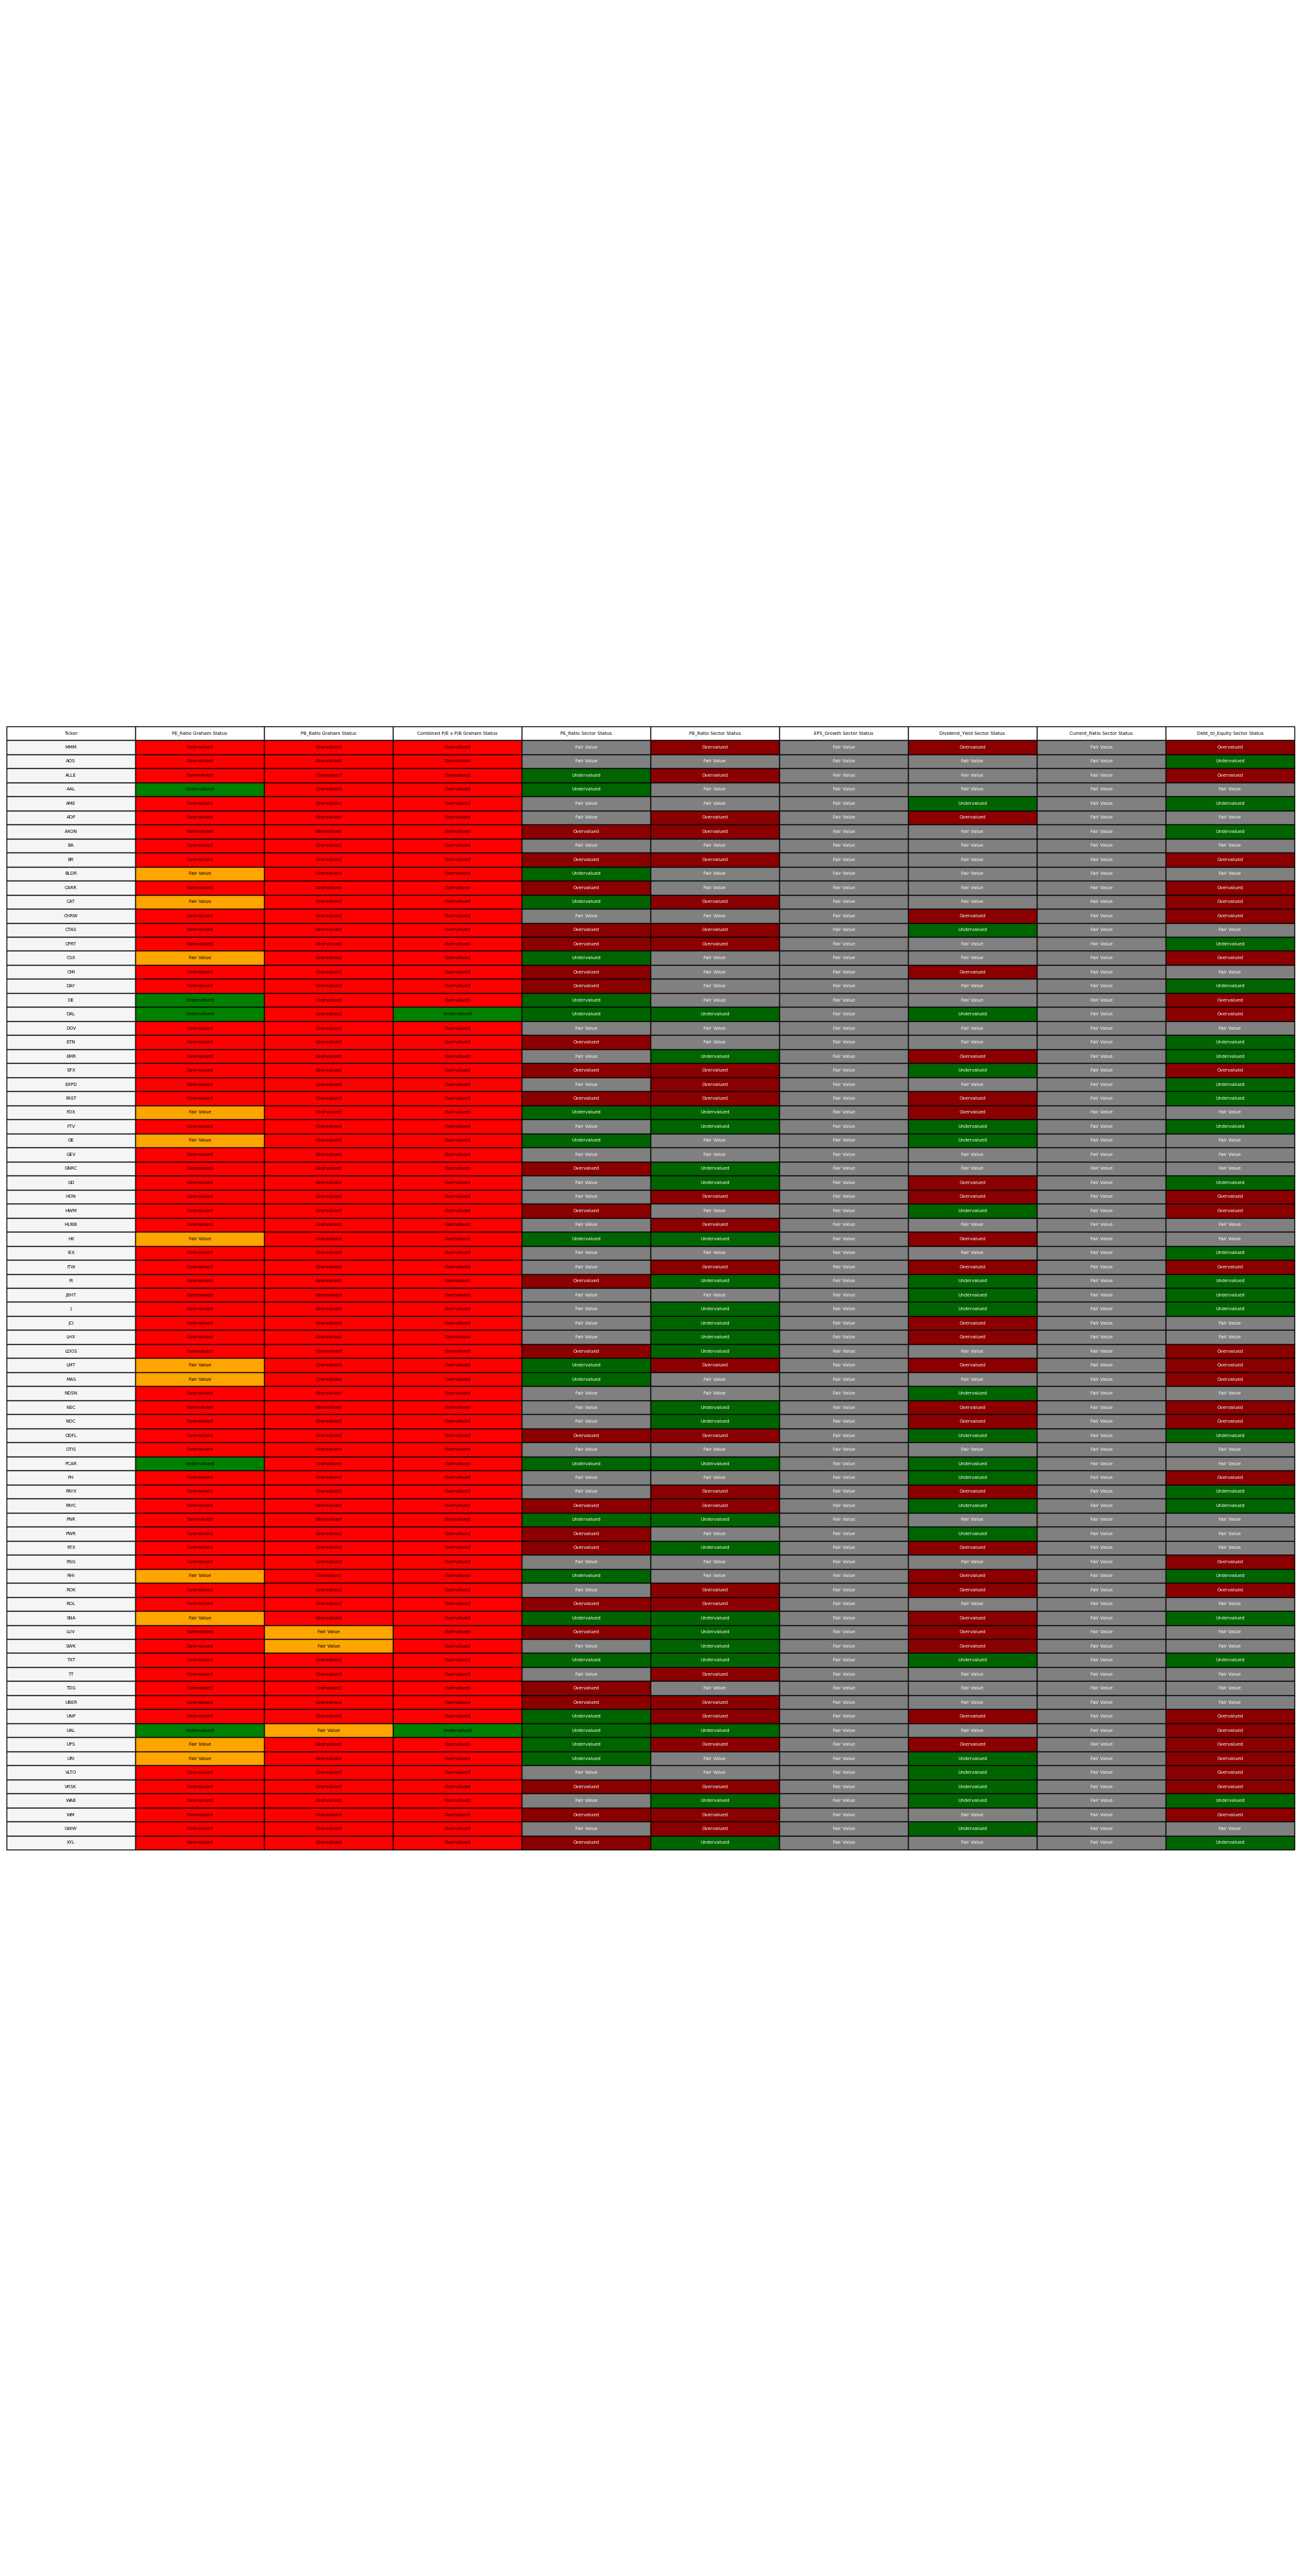

Processing sector: Health Care
Sector Median Metrics for Health Care:
PE_Ratio: 32.23
PB_Ratio: 3.88
EPS_Growth: nan
Dividend_Yield: 0.01
Current_Ratio: nan
Debt_to_Equity: 68.17

Undervalued Companies in Health Care: ['CNC', 'CVS']



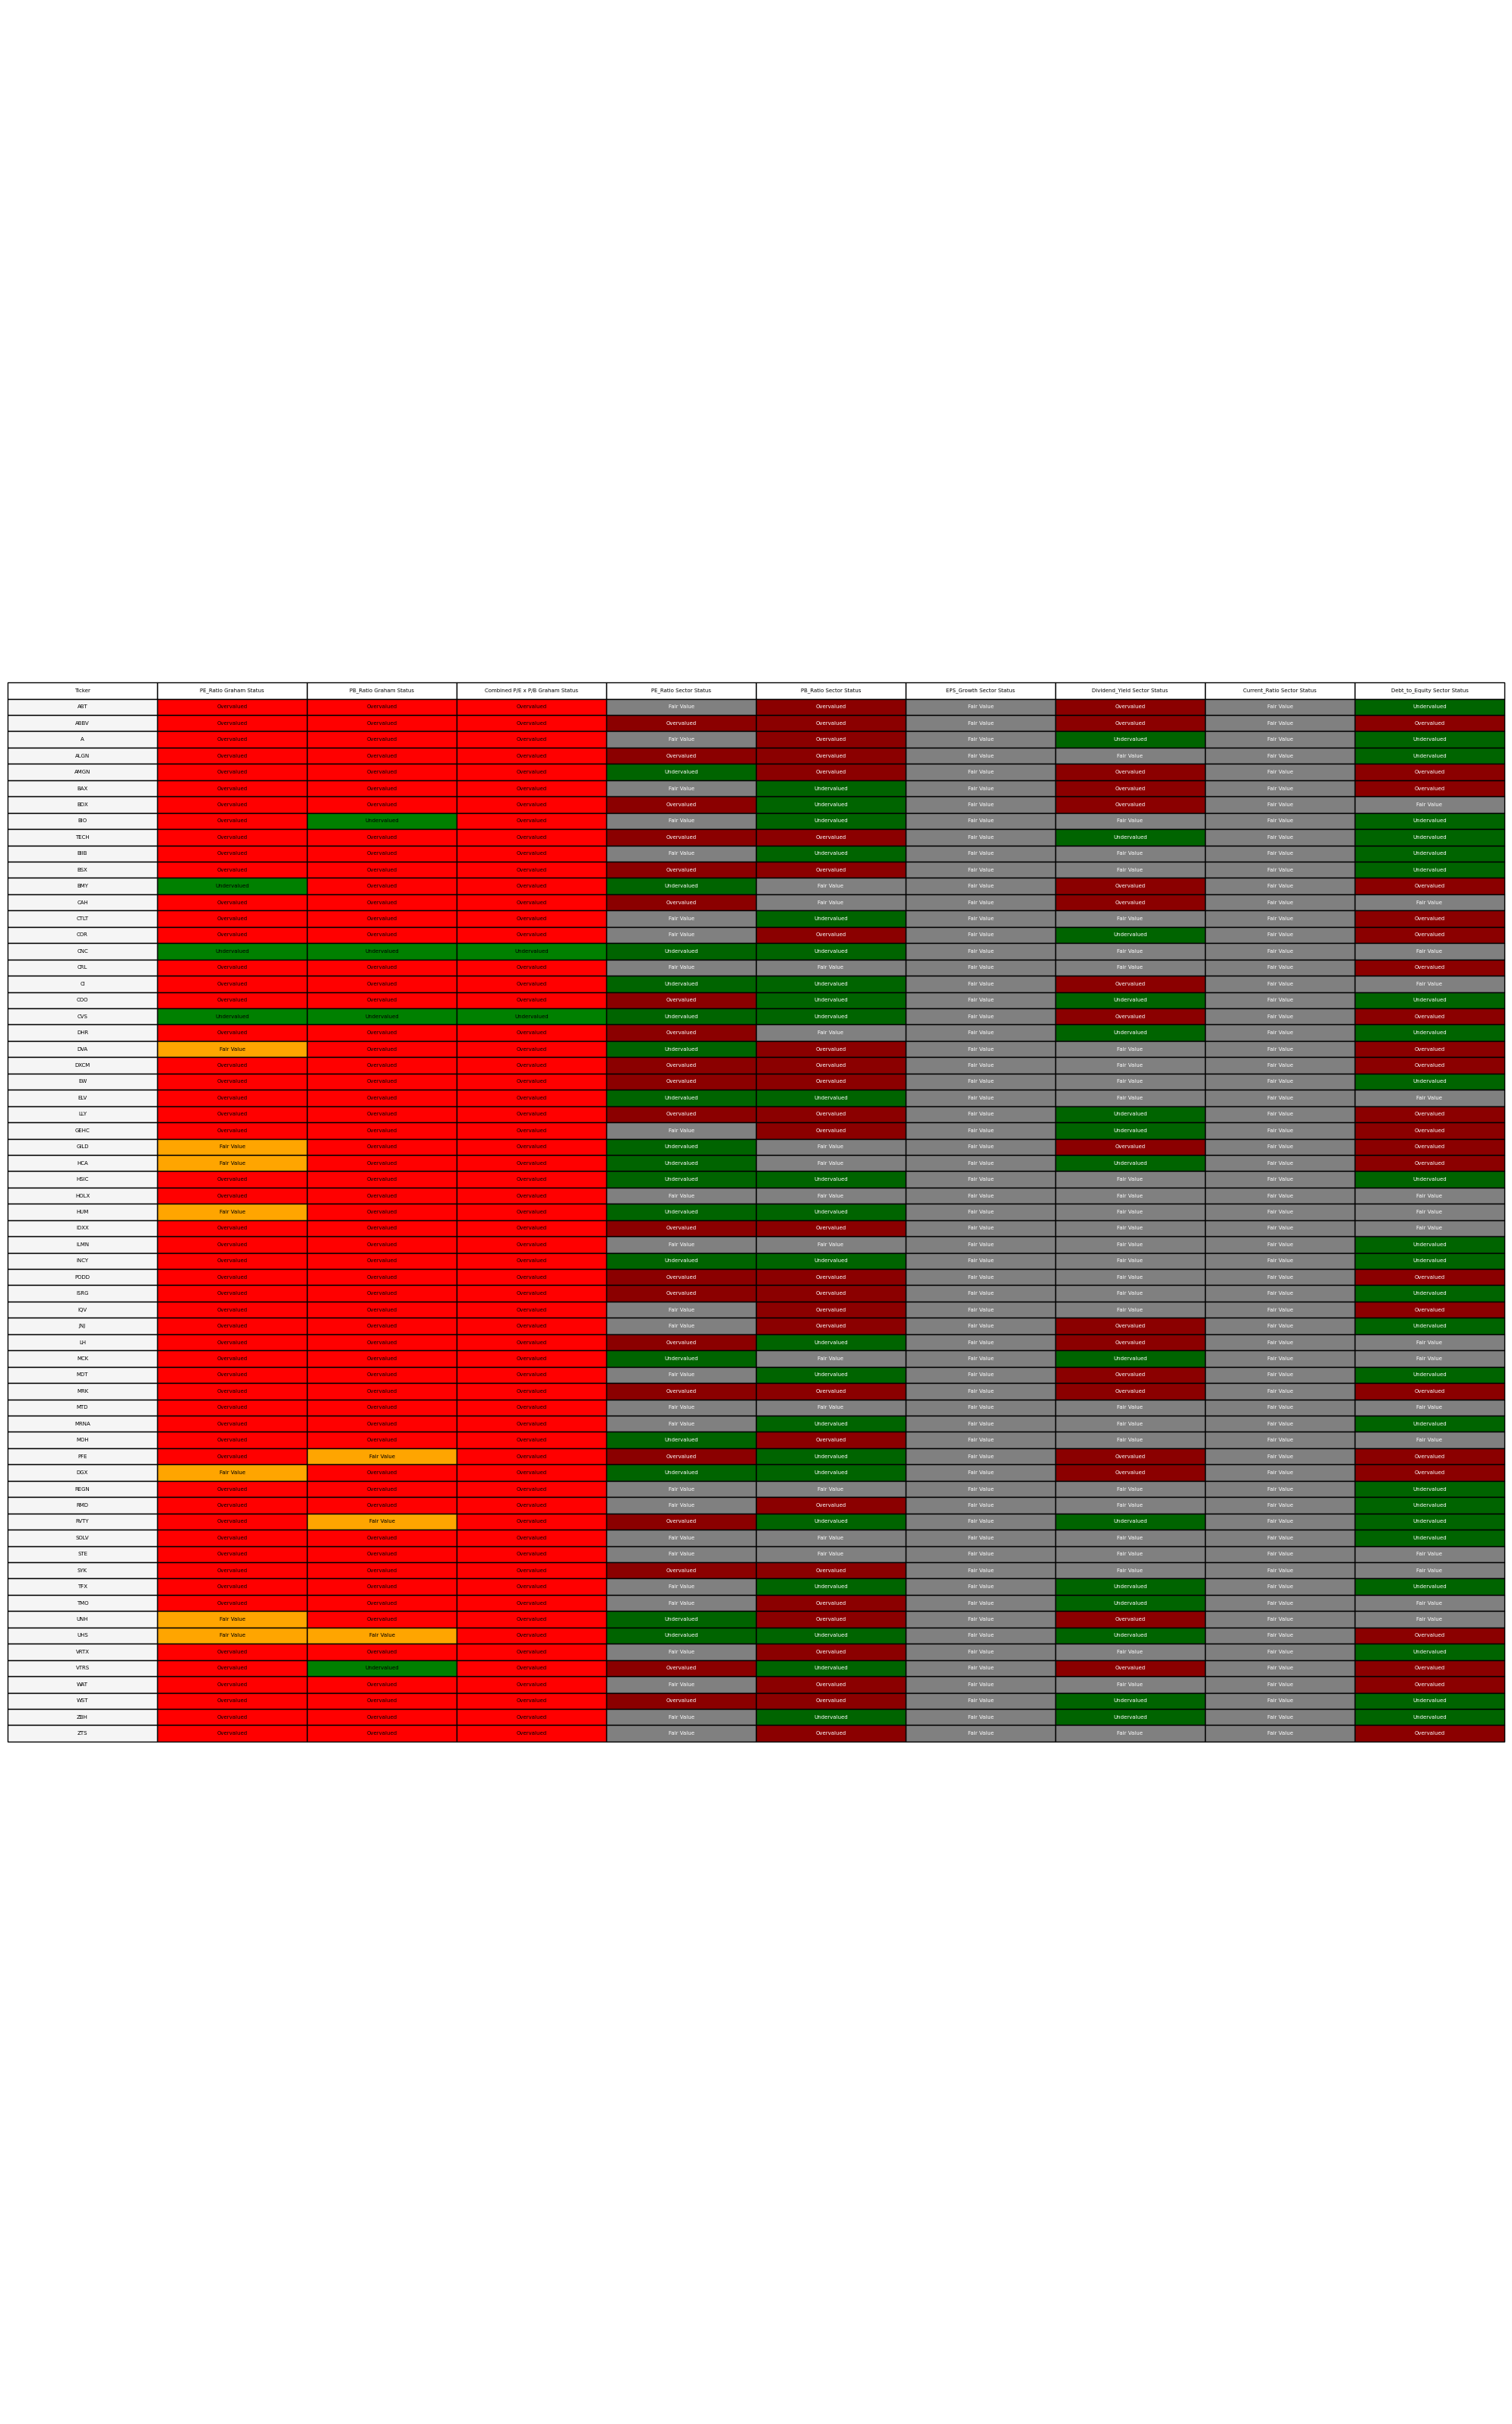

Processing sector: Information Technology
Sector Median Metrics for Information Technology:
PE_Ratio: 37.30
PB_Ratio: 7.16
EPS_Growth: nan
Dividend_Yield: 0.02
Current_Ratio: nan
Debt_to_Equity: 45.84

Undervalued Companies in Information Technology: ['HPE']



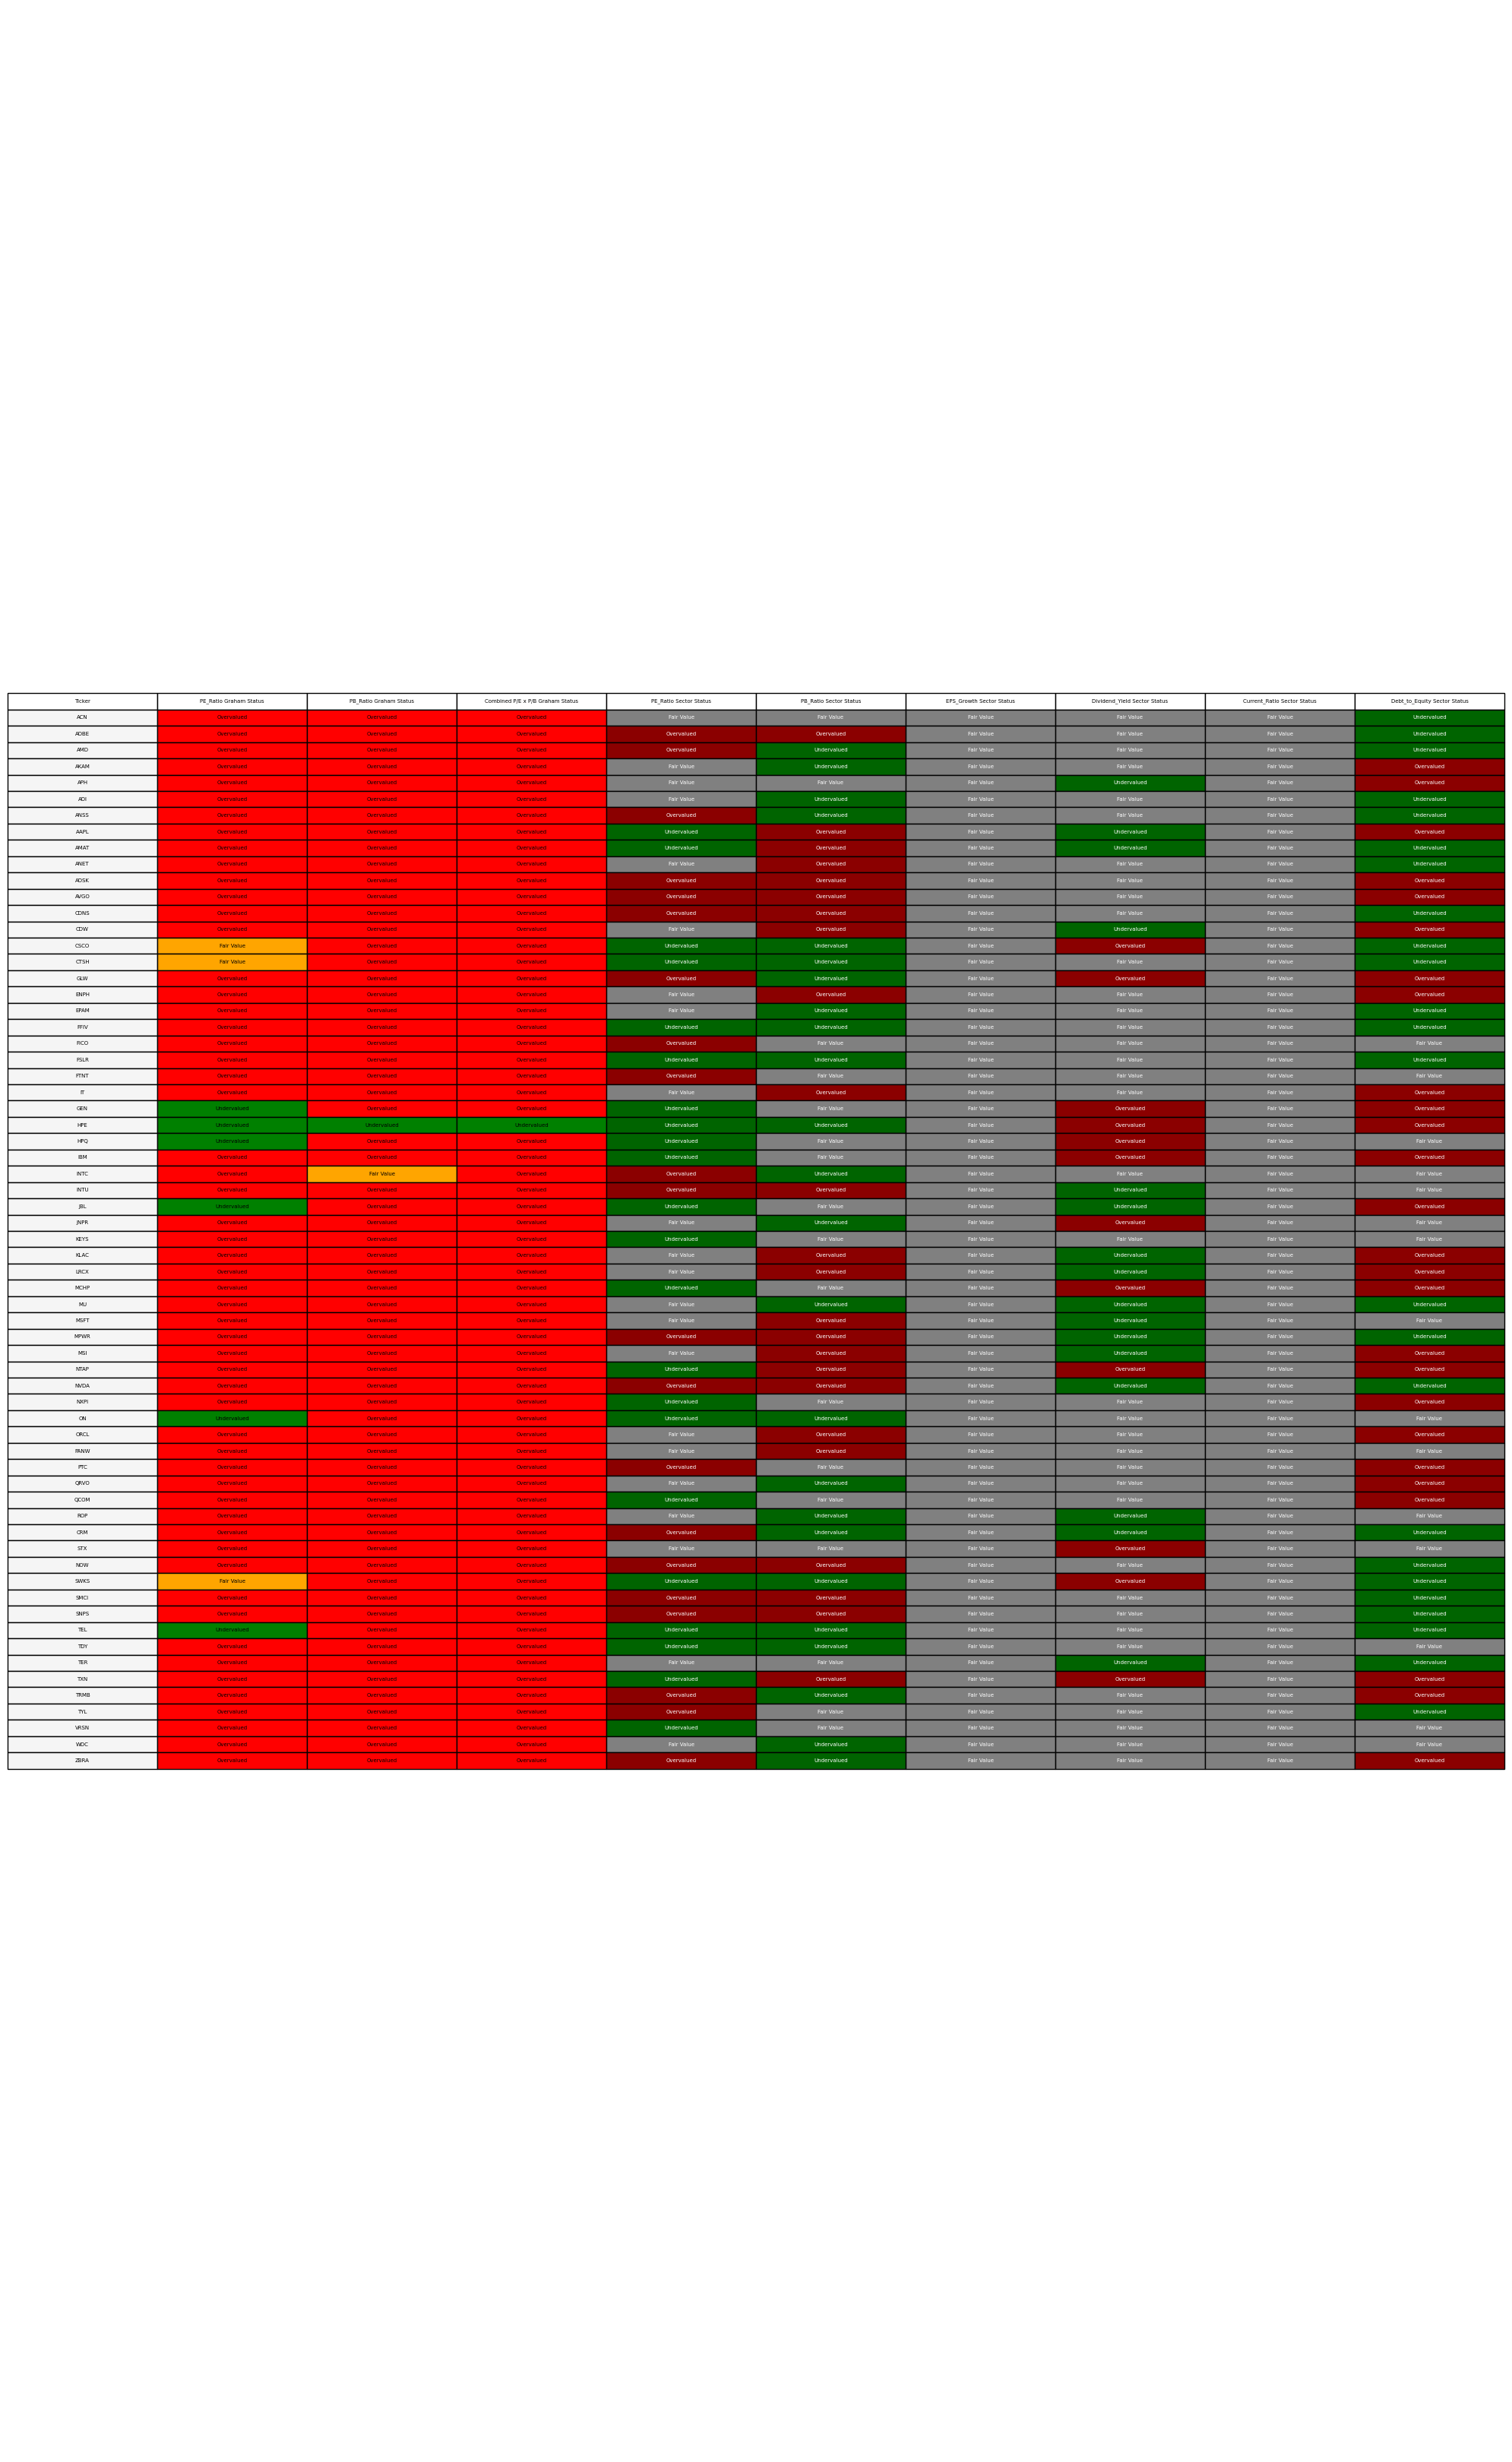

Processing sector: Utilities
Sector Median Metrics for Utilities:
PE_Ratio: 18.38
PB_Ratio: 1.75
EPS_Growth: nan
Dividend_Yield: 0.04
Current_Ratio: nan
Debt_to_Equity: 162.30

Undervalued Companies in Utilities: ['ED', 'ETR', 'EVRG']



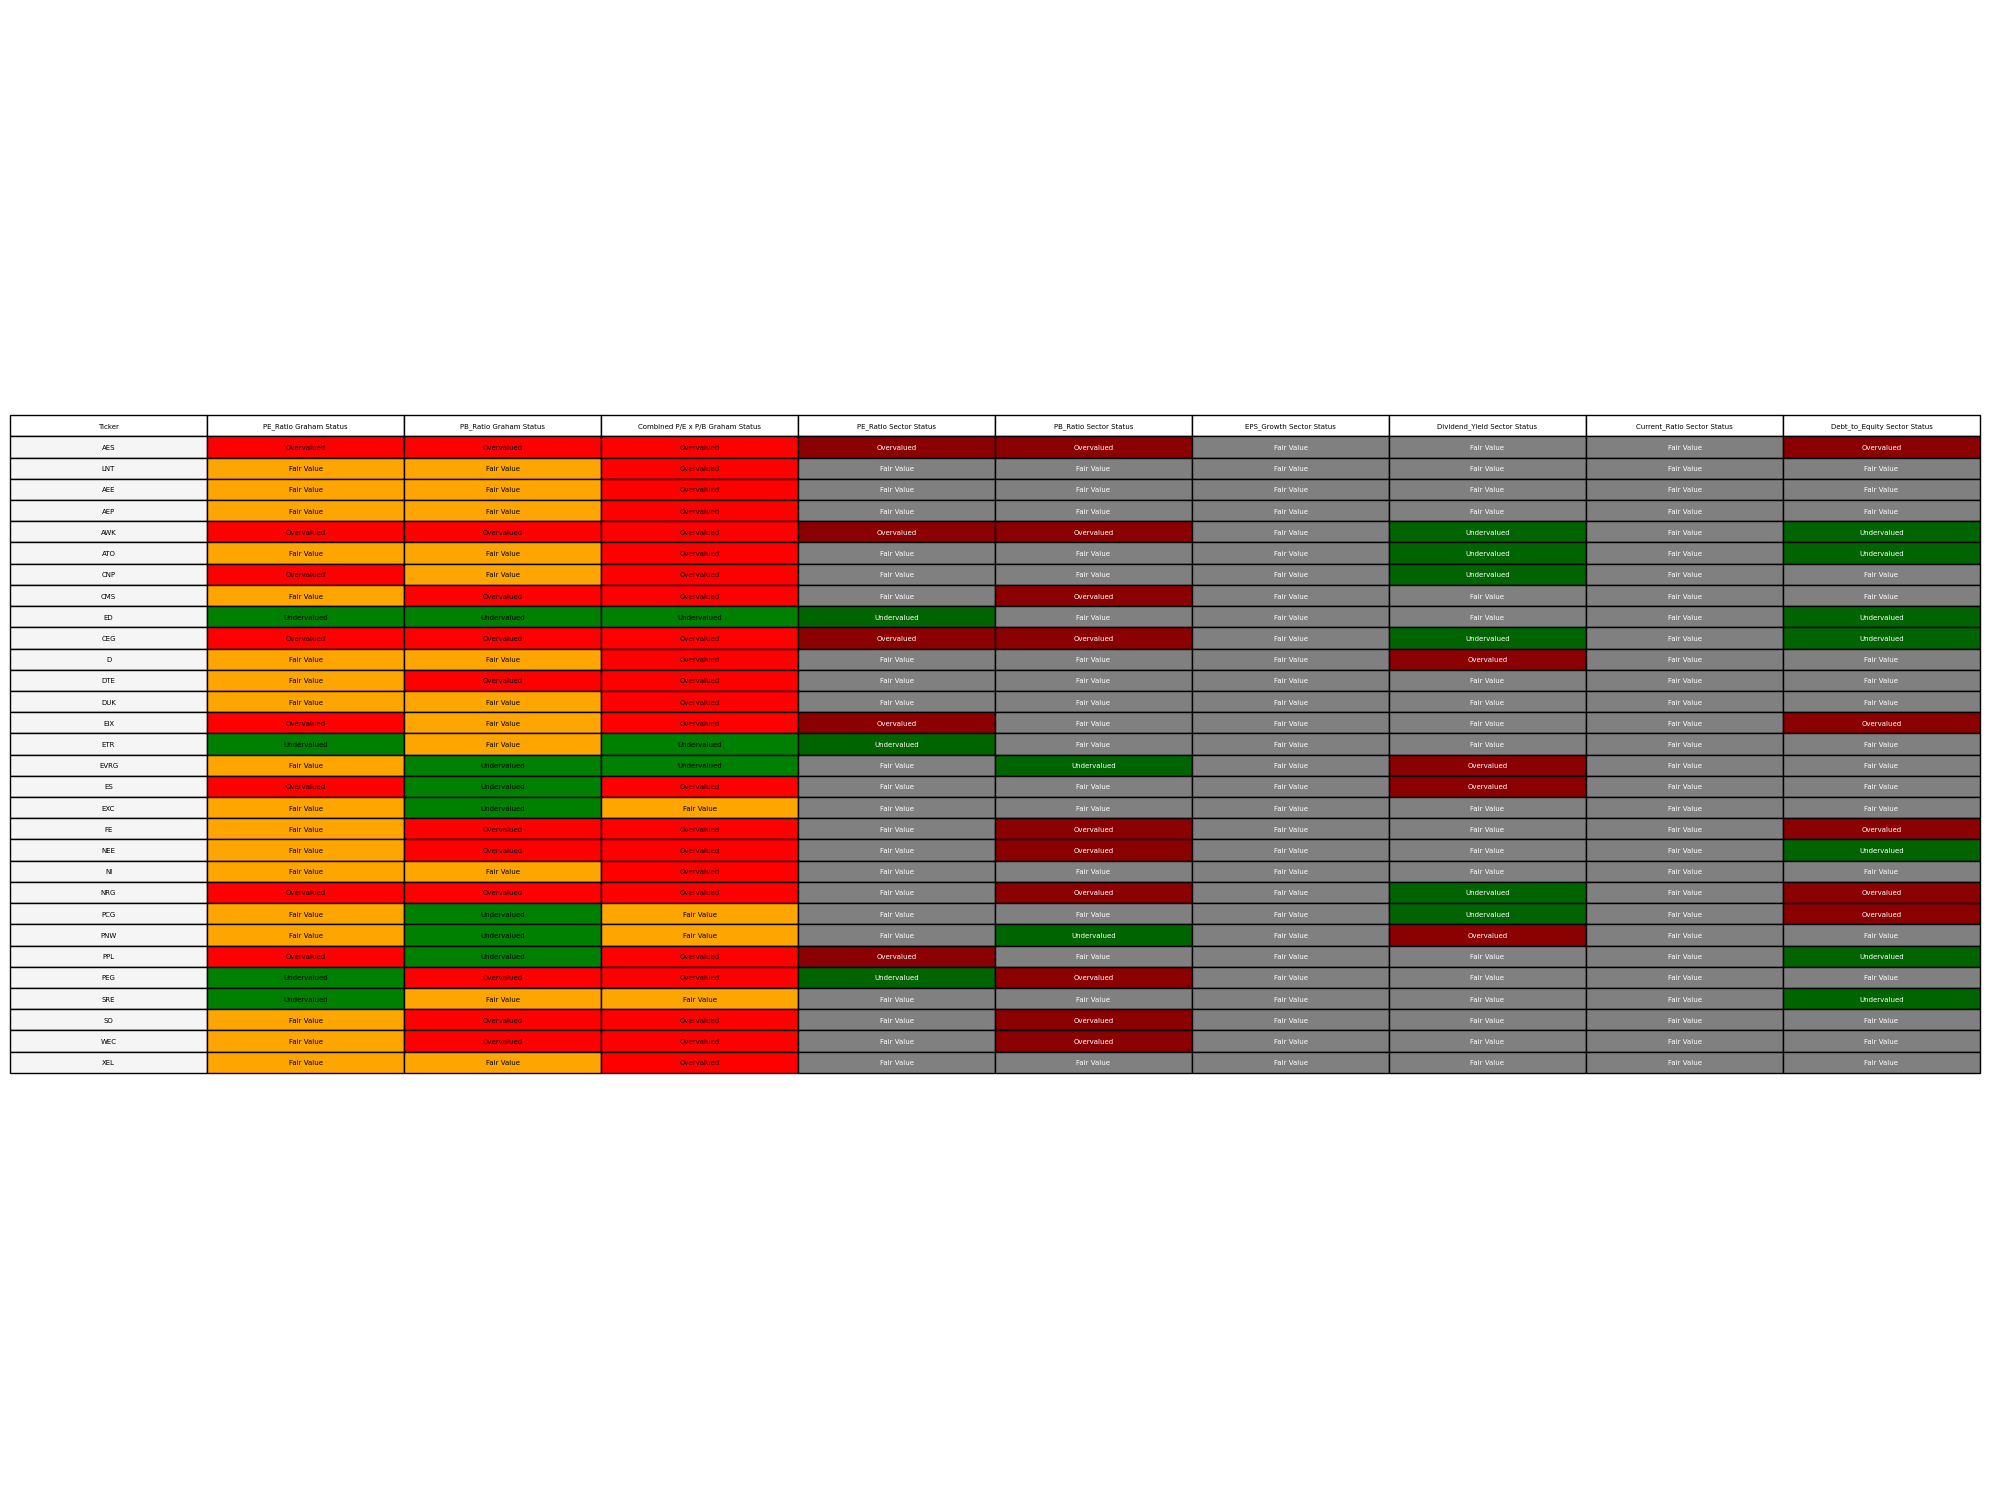

Processing sector: Financials
Sector Median Metrics for Financials:
PE_Ratio: 17.36
PB_Ratio: 1.94
EPS_Growth: nan
Dividend_Yield: 0.02
Current_Ratio: nan
Debt_to_Equity: 52.10

Undervalued Companies in Financials: ['AIG', 'ACGL', 'BAC', 'BK', 'COF', 'CB', 'CINF', 'C', 'CFG', 'CMA', 'EG', 'FITB', 'BEN', 'HBAN', 'KEY', 'L', 'MTB', 'PNC', 'RF', 'STT', 'SYF', 'USB', 'WFC']



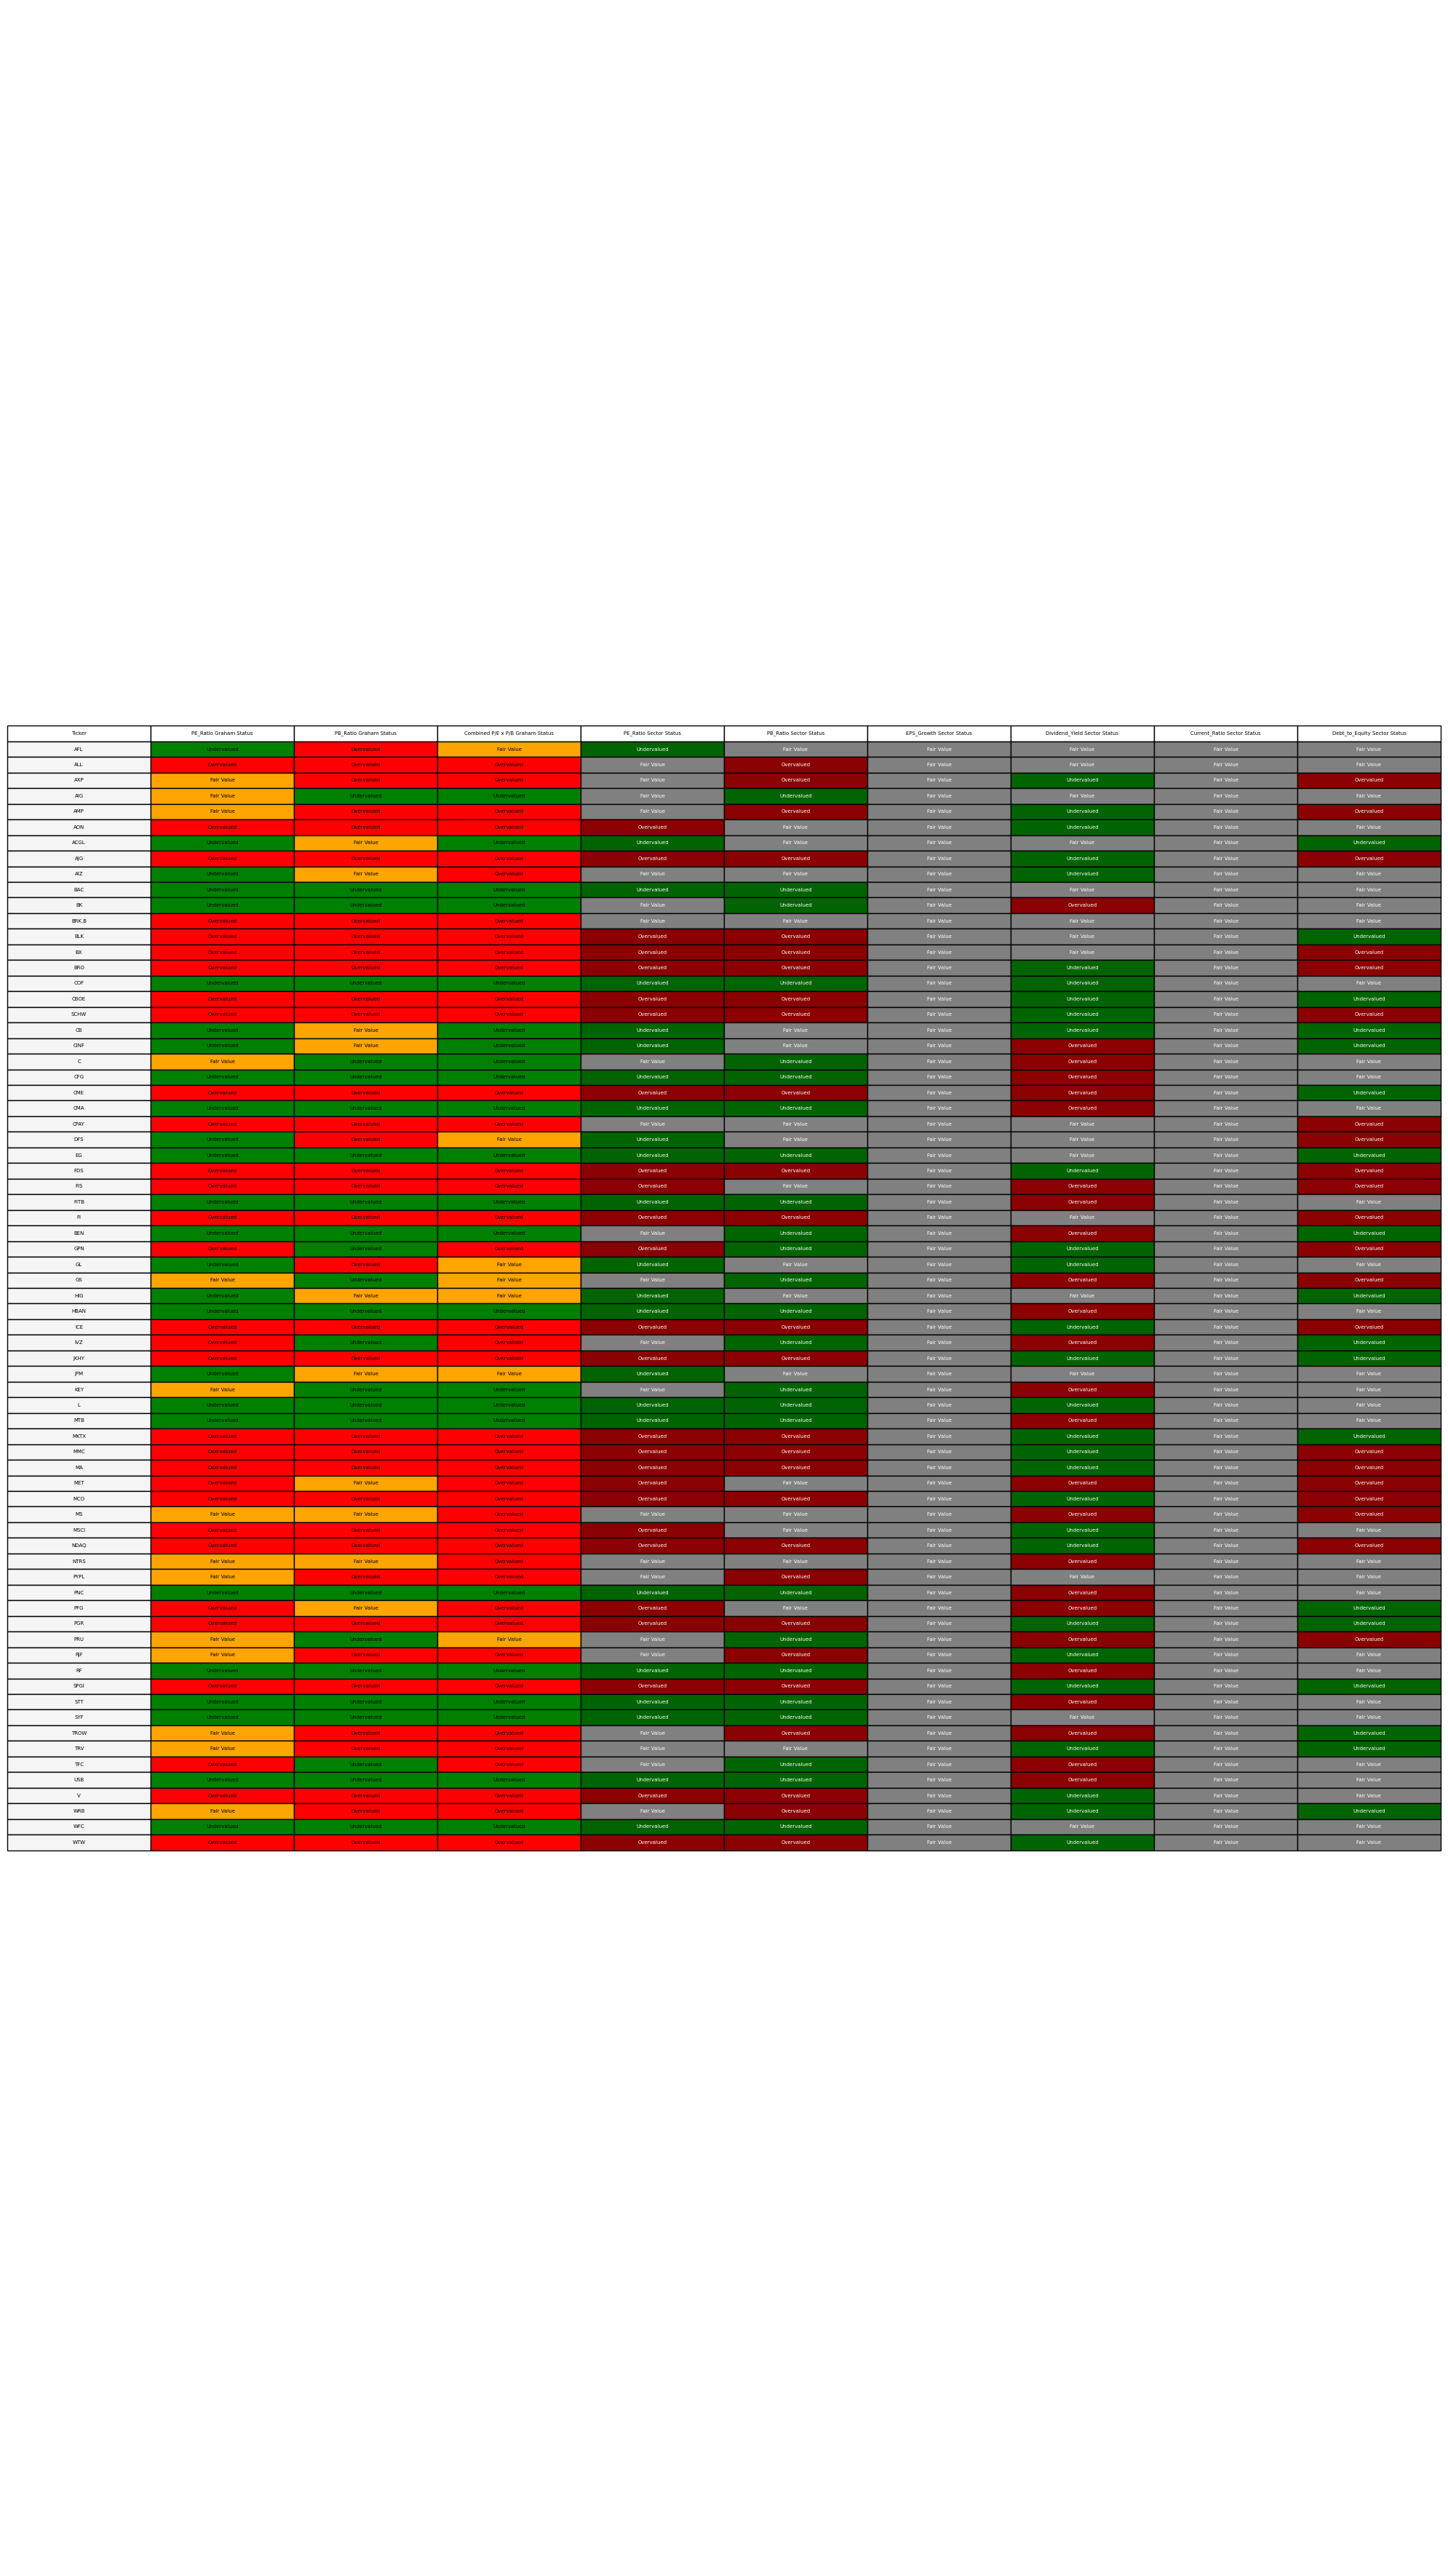

Processing sector: Materials
Sector Median Metrics for Materials:
PE_Ratio: 26.49
PB_Ratio: 2.63
EPS_Growth: nan
Dividend_Yield: 0.02
Current_Ratio: nan
Debt_to_Equity: 76.65

Undervalued Companies in Materials: ['ALB', 'FMC', 'MOS']



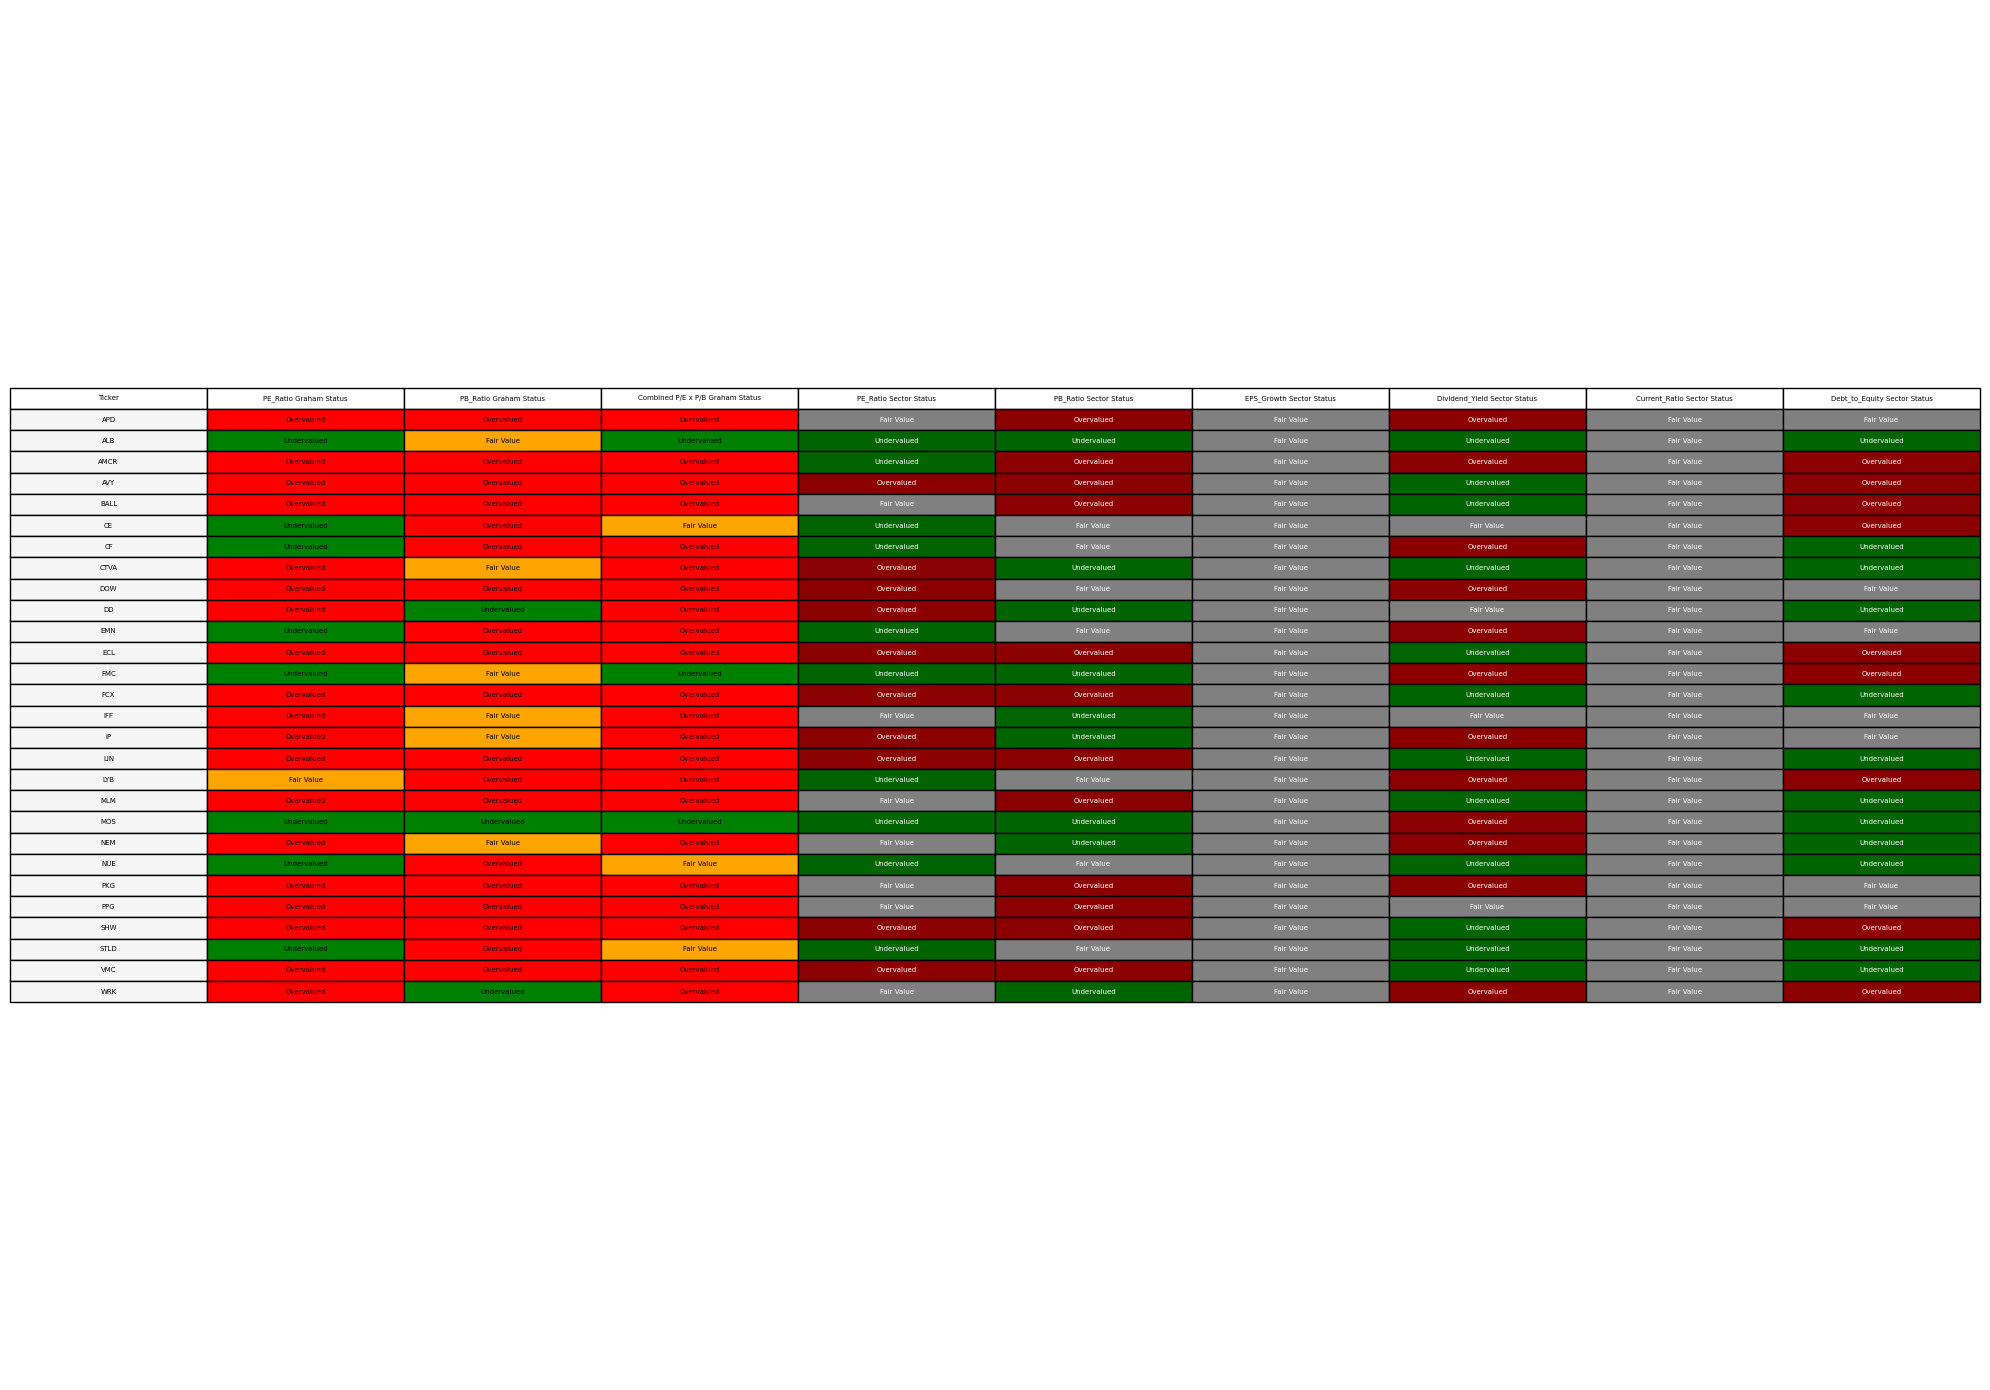

Processing sector: Consumer Discretionary
Sector Median Metrics for Consumer Discretionary:
PE_Ratio: 22.74
PB_Ratio: 5.81
EPS_Growth: nan
Dividend_Yield: 0.02
Current_Ratio: nan
Debt_to_Equity: 117.99

Undervalued Companies in Consumer Discretionary: ['APTV', 'BWA', 'F', 'GM', 'LEN']



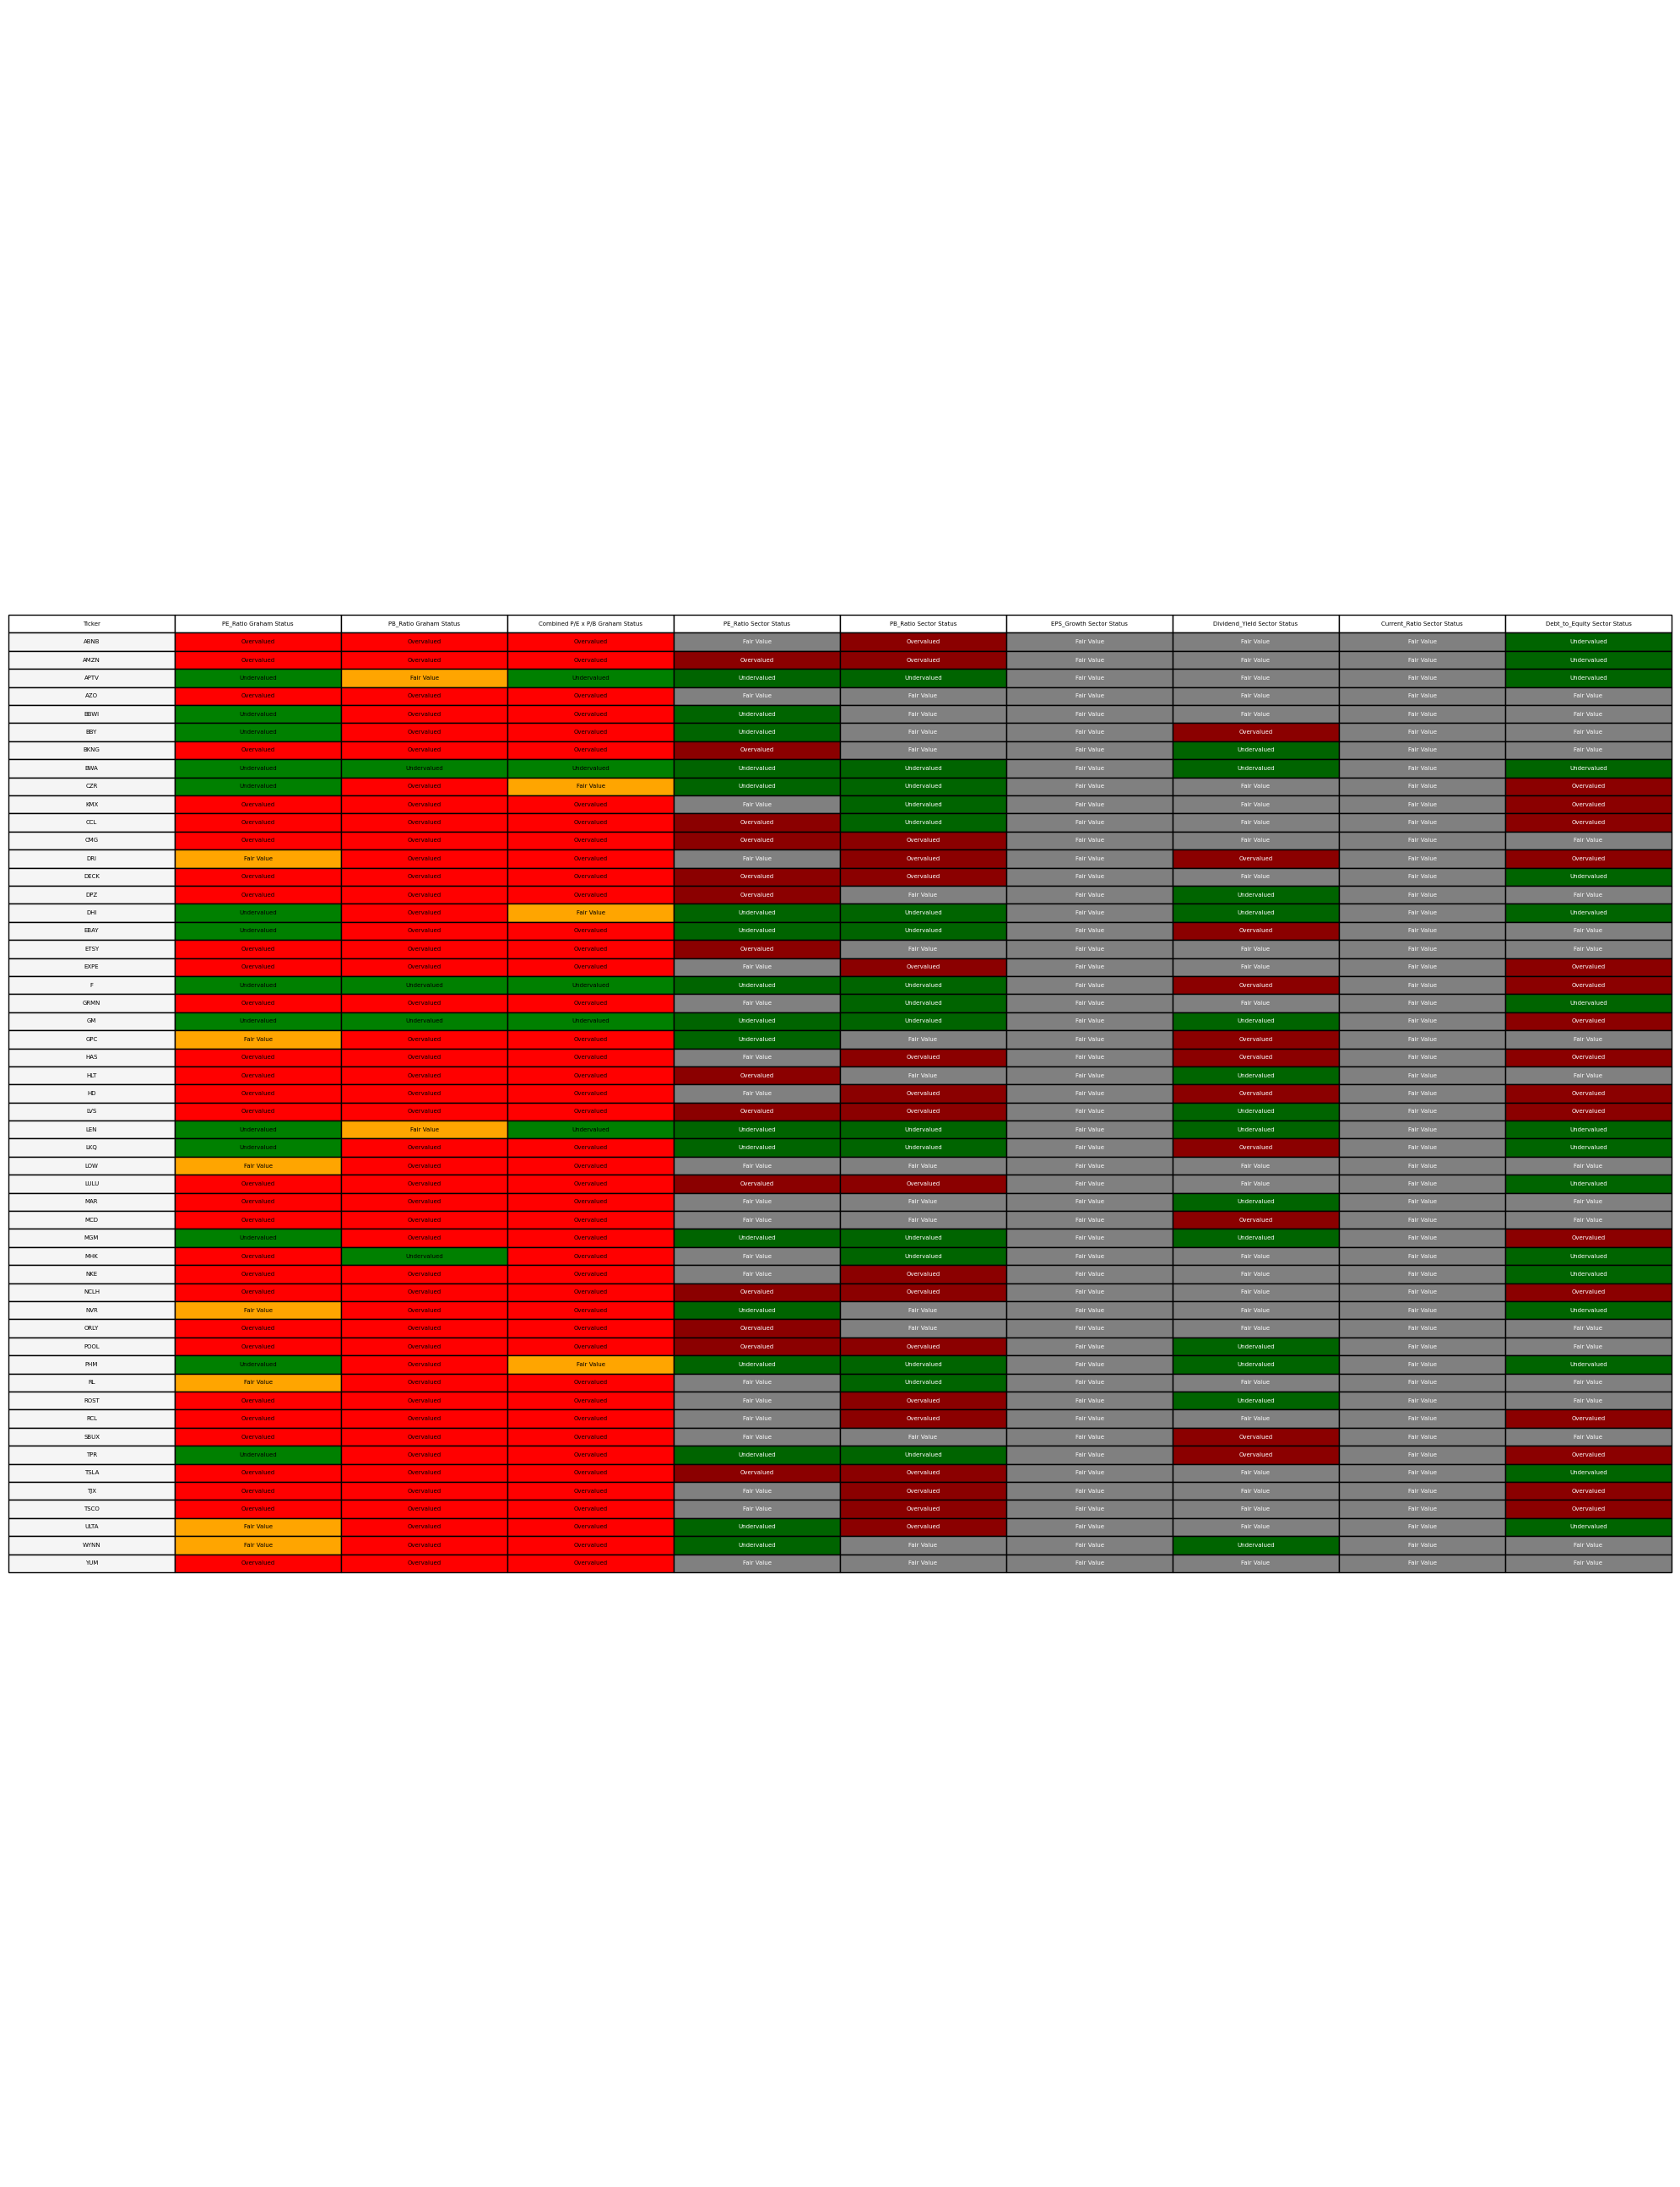

Processing sector: Real Estate
Sector Median Metrics for Real Estate:
PE_Ratio: 33.10
PB_Ratio: 2.27
EPS_Growth: nan
Dividend_Yield: 0.04
Current_Ratio: nan
Debt_to_Equity: 76.83

Undervalued Companies in Real Estate: ['KIM', 'VICI']



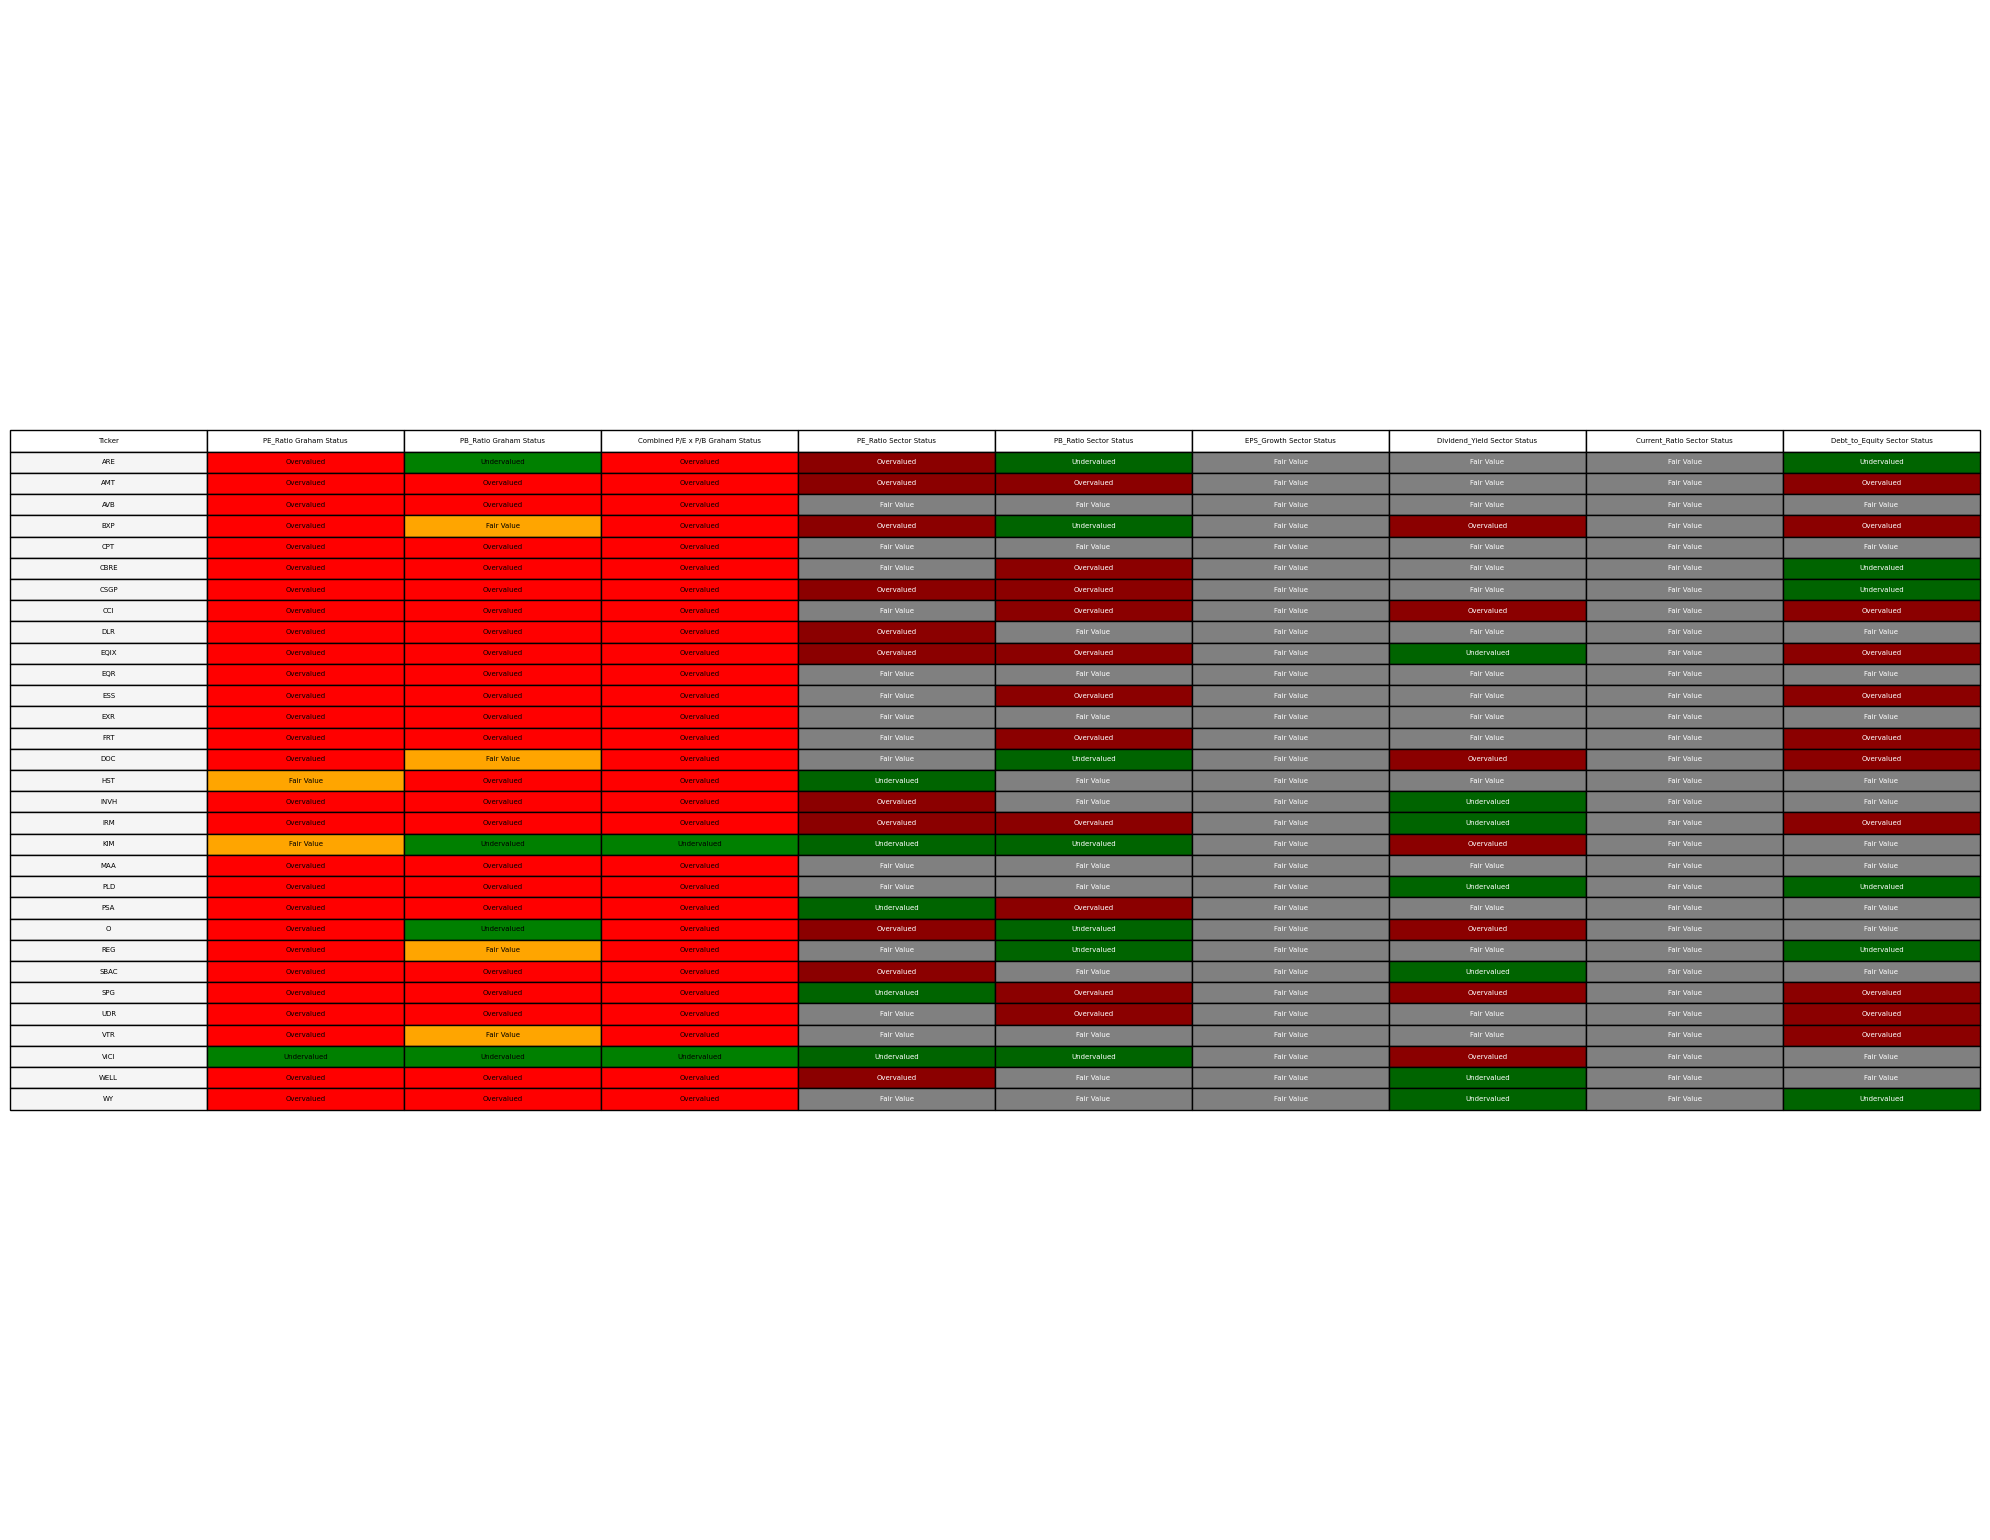

Processing sector: Communication Services
Sector Median Metrics for Communication Services:
PE_Ratio: 23.17
PB_Ratio: 2.59
EPS_Growth: nan
Dividend_Yield: 0.02
Current_Ratio: nan
Debt_to_Equity: 89.04

Undervalued Companies in Communication Services: ['T', 'CMCSA', 'FOX']



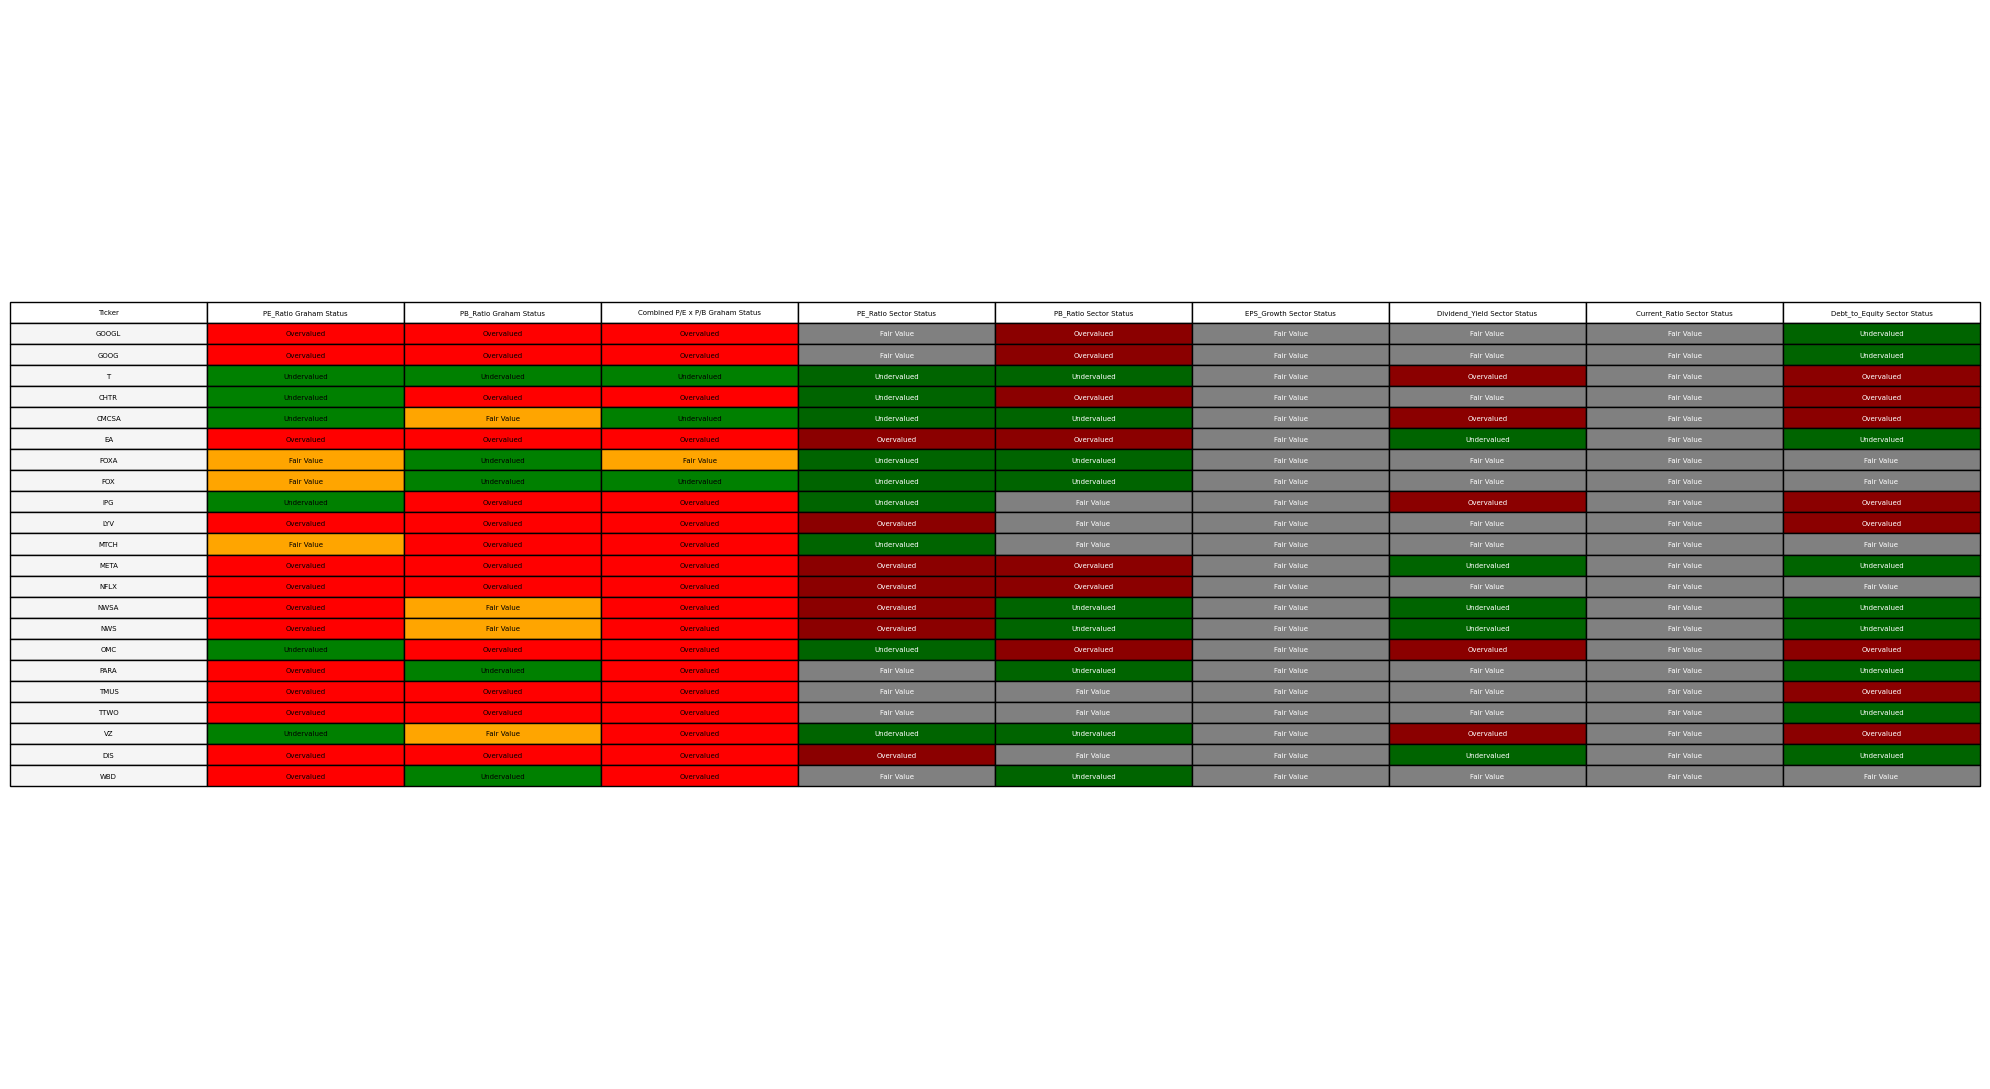

Processing sector: Consumer Staples
Sector Median Metrics for Consumer Staples:
PE_Ratio: 21.88
PB_Ratio: 5.02
EPS_Growth: nan
Dividend_Yield: 0.03
Current_Ratio: nan
Debt_to_Equity: 119.39

Undervalued Companies in Consumer Staples: ['ADM', 'BG', 'KHC', 'TAP']



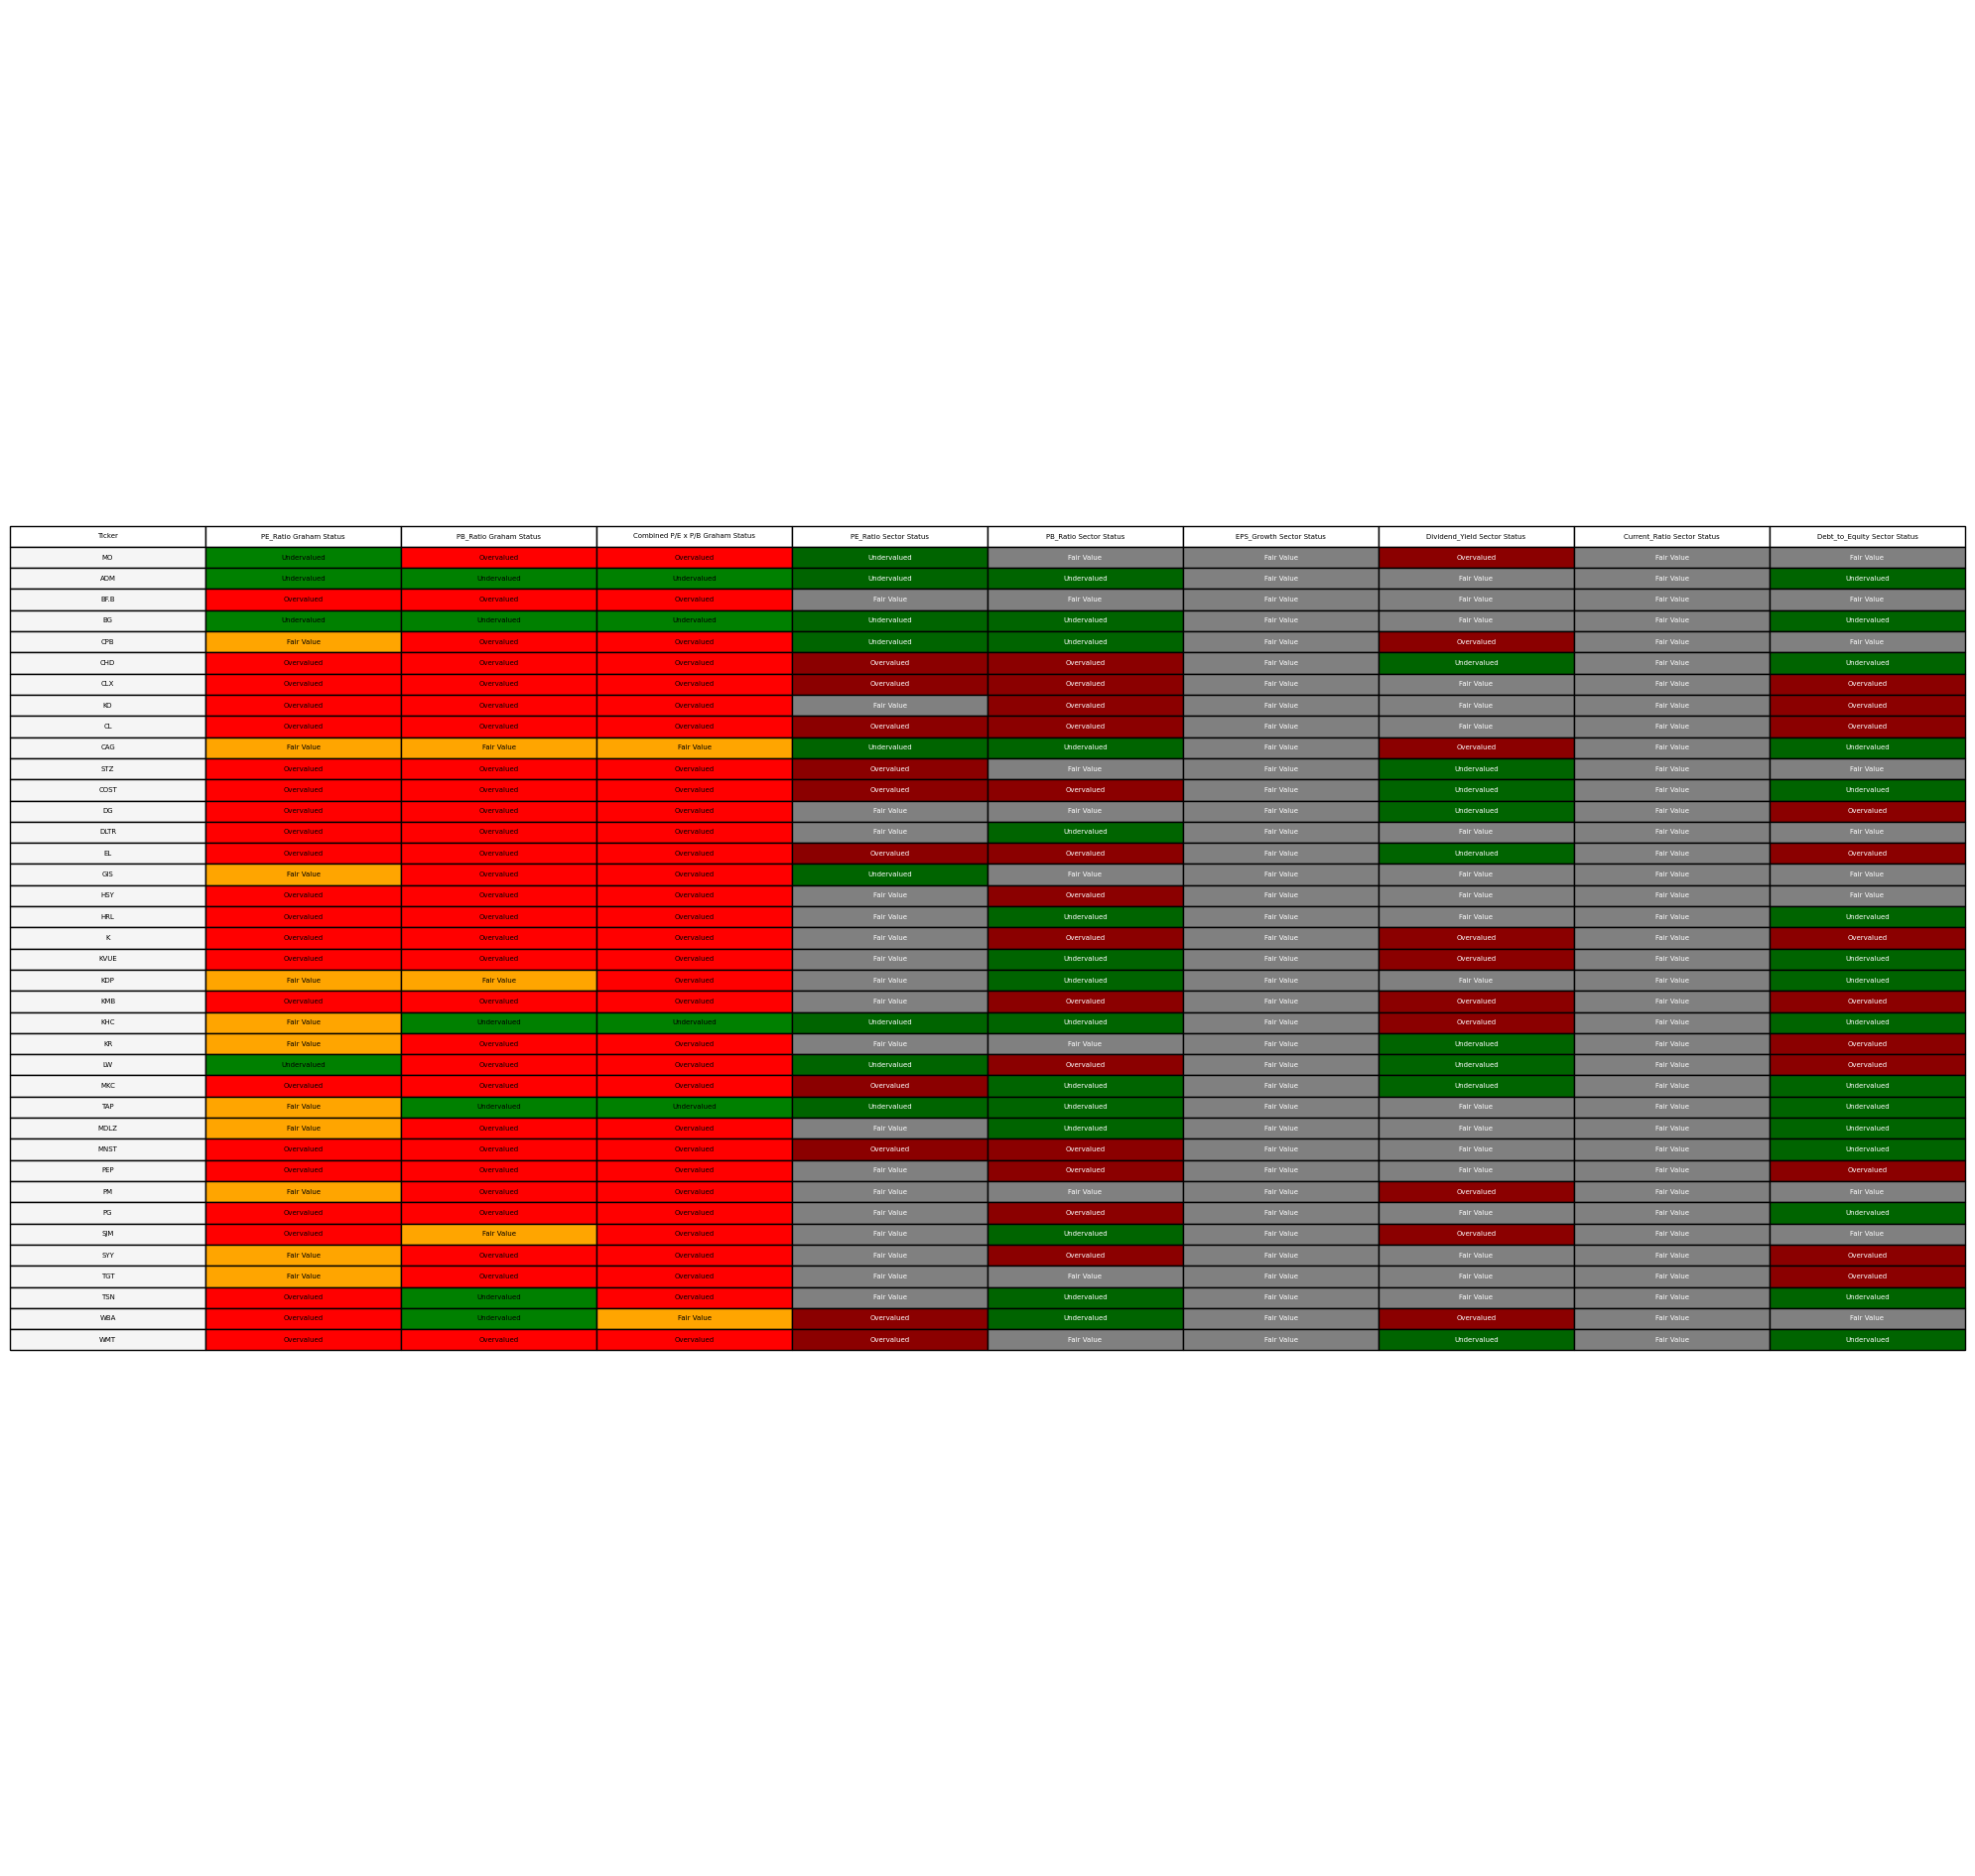

Processing sector: Energy
Sector Median Metrics for Energy:
PE_Ratio: 13.59
PB_Ratio: 2.74
EPS_Growth: nan
Dividend_Yield: 0.03
Current_Ratio: nan
Debt_to_Equity: 53.06

Undervalued Companies in Energy: ['APA', 'CTRA', 'EQT', 'MRO', 'VLO']



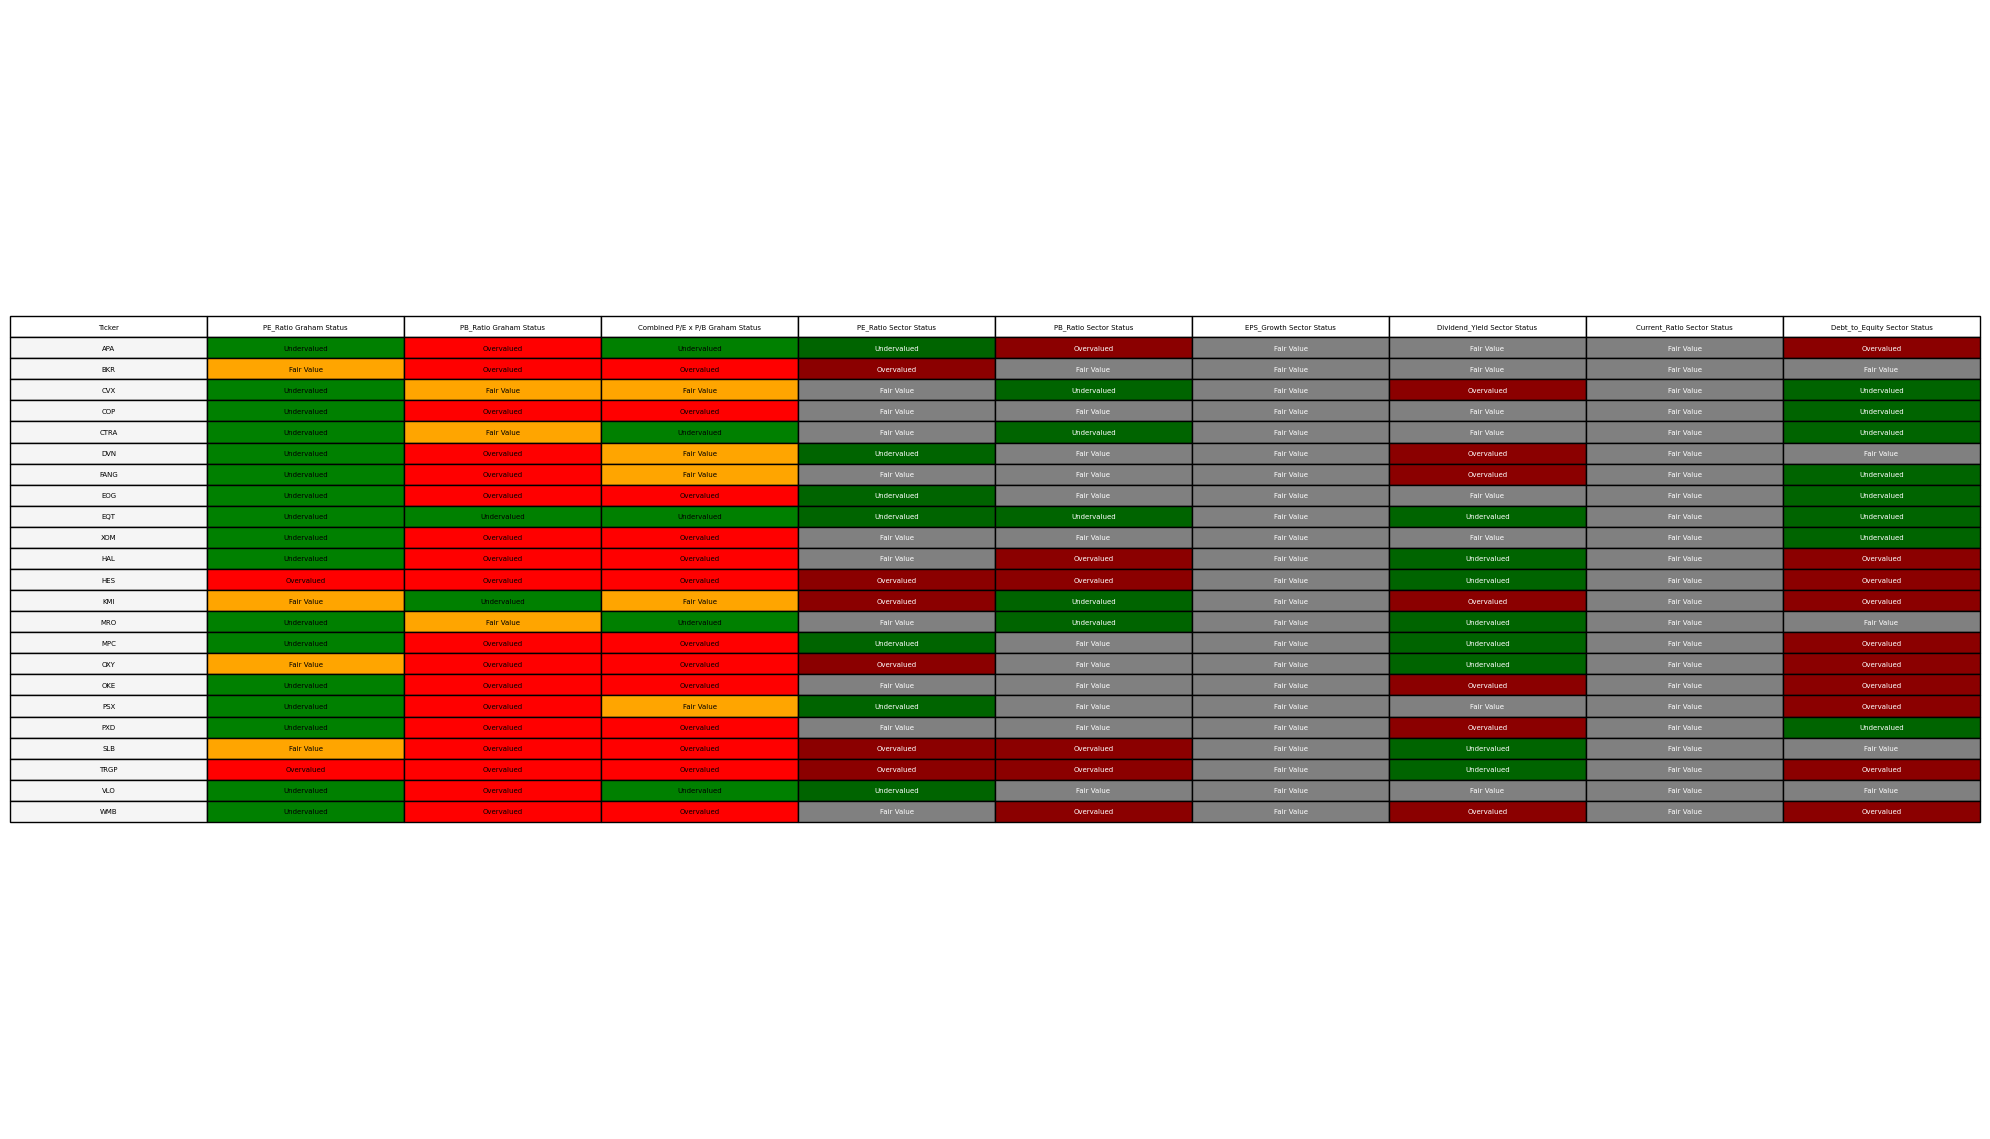

In [9]:
# Process each sector
for sector in unique_sectors:
    process_sector(sector, sp500_df)